In [ ]:
# PTD-VRP-D End-to-End Simulation Notebook
# ========================================

# =========================
# Imports
# =========================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d
from pyswarm import pso

import gurobipy as gp
from gurobipy import GRB

# =========================
# Constants & Parameters
# =========================
AREA_SIZE        = 10.0      # km
N_DELIVERY_LOC   = 10
DEPOT            = (0.0, 0.0)
DRONE_ENDURANCE  = 20.0      # minutes
N_DRONES         = 10
DRONE_SPEED      = 40.0      # km/h
SERVICE_TIME     = 5.0       # minutes per cluster visit
PENALTY          = 1e3       # penalty for endurance violation

# PSO / solver settings
MAX_PSO_ITERS    = 10
PSO_SWARMSIZE    = 30
# coarse solve (used by baseline & PSO objective)
TIME_LIMIT_COARSE = 5        # seconds
MIP_GAP_COARSE    = 0.05     # 5%
# fine “polish” solve
TIME_LIMIT_FINE   = 60       # seconds
MIP_GAP_FINE      = 1e-4     # 0.01%

# PWL breakpoints for 24h speed profile (15-min)
DT    = 0.25
TIMES = np.arange(0, 24 + DT, DT)

# =========================
# Utility Functions
# =========================
def generate_random_locations(n, depot, range_km=AREA_SIZE):
    """Generate n random delivery points around depot."""
    pts = np.random.uniform(-range_km, range_km, size=(n,2))
    return np.vstack([depot, pts])

def load_speed_model(csv_path='Predicted_Speeds.csv'):
    """Load or synthesize a 15-min truck-speed profile over 24h."""
    if not os.path.exists(csv_path):
        # synthetic “rush‐hour” pattern
        speeds = 60 + 10*np.sin((TIMES-12)/24*2*np.pi)
        speeds -= 20*(np.exp(-((TIMES-8)/1.5)**2) + np.exp(-((TIMES-17)/1.5)**2))
        speeds = np.clip(speeds, 20, 80)
        pd.DataFrame({'Time of Day': TIMES, 'Predicted Speed': speeds})\
          .to_csv(csv_path, index=False)
    df = pd.read_csv(csv_path).sort_values('Time of Day')
    return interp1d(df['Time of Day'], df['Predicted Speed'],
                    kind='linear', fill_value='extrapolate')

def is_within_endurance(center, pts):
    """Check drone round-trip feasibility for all pts in one cluster."""
    d     = np.linalg.norm(pts - center, axis=1)
    T_rt  = 2*(d/DRONE_SPEED) + (SERVICE_TIME/60.0)
    return np.all(T_rt <= (DRONE_ENDURANCE/60.0))

# =========================
# Adaptive K-Means Clustering
# =========================
def adaptive_kmeans(locs):
    """Find smallest K so each cluster is drone-feasible."""
    N = len(locs) - 1
    for K in range(1, N+1):
        km      = KMeans(n_clusters=K, n_init=10, random_state=0).fit(locs[1:])
        centers = km.cluster_centers_
        labels  = km.labels_
        if all(is_within_endurance(centers[i], locs[1:][labels==i])
               for i in range(K)):
            return labels, centers
    raise RuntimeError("No valid clustering found")

# =========================
# MILP Core (time‐dependent PWL + truck–drone sync)
# =========================
env = gp.Env(empty=True)
env.setParam('WLSACCESSID','95c3994f-513d-4b8c-a42c-0194dad8ec5c')
env.setParam('WLSSECRET',  '3dc0e444-1f74-49f3-96cc-e9abaabb8ce4')
env.setParam('LICENSEID',   2551395)
env.start()
def solve_time_dependent_milp(alpha, centers, labels, speed_func, locs,
                              time_limit, mip_gap):
    """
    alpha: (K,1) scaling of cluster centers
    centers: (K,2) original centers
    labels:   length N labels
    speed_func: interpolation speed(t)
    locs: full array including depot
    """
    # 1) adjust centers, build coords + Manhattan distances
    adj      = centers * alpha
    K        = len(centers)
    coords   = np.vstack([DEPOT, adj])
    dM       = np.abs(coords[:,None,0] - coords[None,:,0]) + \
               np.abs(coords[:,None,1] - coords[None,:,1])

    # 2) Gurobi env & model


    m = gp.Model(env=env)
    m.Params.OutputFlag = 0
    m.Params.TimeLimit  = time_limit
    m.Params.MIPGap     = mip_gap

    # 3) decision vars
    r      = m.addVars(K+1,K+1, vtype=GRB.BINARY,      name='r')
    u      = m.addVars(K+1,    vtype=GRB.CONTINUOUS, lb=0, ub=K, name='u')
    Tdep   = m.addVars(K+1,    vtype=GRB.CONTINUOUS,      name='Tdep')
    Tarr   = m.addVars(K+1,    vtype=GRB.CONTINUOUS,      name='Tarr')
    Tdrone = m.addVars(K+1,    vtype=GRB.CONTINUOUS,      name='Tdrone')
    τ      = m.addVars(K+1,K+1, vtype=GRB.CONTINUOUS,      name='tau') 

    # drone-assignment y[i,ℓ,k]
    y = {}
    for i in range(1,K+1):
        pts = locs[1:][labels==i-1]
        for ℓ in range(len(pts)):
            for k in range(N_DRONES):
                y[i,ℓ,k] = m.addVar(vtype=GRB.BINARY, name=f"y_{i}_{ℓ}_{k}")

    # 4) PWL inv-speed breakpoints
    inv_speeds = (1.0/speed_func(TIMES)).tolist()
    t_breaks   = TIMES.tolist()

    # 5) objective = truck + drone + service
    truck_cost = gp.quicksum( τ[i,j] * r[i,j]
                              for i in range(K+1) for j in range(K+1) if i!=j )
    drone_cost = gp.quicksum(Tdrone[i] for i in range(1,K+1))
    service    = SERVICE_TIME/60.0 * K
    m.setObjective(truck_cost + drone_cost + service, GRB.MINIMIZE)

    # 6) PWL constraints: τ[i,j] = dM[i,j]*inv_speed(Tdep[i])
    for i in range(K+1):
        for j in range(K+1):
            if i==j: continue
            ys = (dM[i,j] * np.array(inv_speeds)).tolist()
            m.addGenConstrPWL(τ[i,j], Tdep[i], t_breaks, ys,
                              name=f"pwl_{i}_{j}")

    # 7) routing & subtours (MTZ)
    for i in range(K+1):
        m.addConstr(r.sum(i,'*') == 1)
        m.addConstr(r.sum('*',i) == 1)
    m.addConstr(u[0]==0)
    for i in range(1,K+1):
        for j in range(1,K+1):
            if i!=j:
                m.addConstr(u[i] - u[j] + (K+1)*r[i,j] <= K)

    # 8) timing chain: Tarr[j] ≥ Tdep[i] + τ[i,j]  if arc used
    M = 1e3
    for i in range(K+1):
        for j in range(K+1):
            if i!=j:
                m.addConstr( Tarr[j] >= Tdep[i] + τ[i,j] - M*(1-r[i,j]) )
    for i in range(K+1):
        m.addConstr(Tdep[i] >= Tarr[i] + SERVICE_TIME/60.0)
    for i in range(1,K+1):
        m.addConstr(Tdep[i] >= Tarr[i] + Tdrone[i])

    # 9) drone schedule + endurance
    for i in range(1,K+1):
        pts = locs[1:][labels==i-1]
        if pts.size>0:
            dE = [float(np.linalg.norm(pt - adj[i-1])) for pt in pts]
            # each ℓ assigned exactly once
            for ℓ in range(len(dE)):
                m.addConstr( gp.quicksum(y[i,ℓ,k] for k in range(N_DRONES)) == 1 )
            # workloads & Tdrone
            for k in range(N_DRONES):
                m.addConstr( Tdrone[i] >= 
                    gp.quicksum( 2*dE[ℓ]/DRONE_SPEED * y[i,ℓ,k]
                                 for ℓ in range(len(dE))) )
            # endurance
            for d in dE:
                m.addConstr(2*d/DRONE_SPEED <= DRONE_ENDURANCE/60.0)
        else:
            m.addConstr(Tdrone[i]==0)

    m.optimize()
    return m.ObjVal if m.status==GRB.OPTIMAL else 1e6

# =========================
# PSO Objective (no caching)
# =========================
def objective(w, centers, labels, locs, speed_func):
    alpha   = np.array(w).reshape(-1,1)
    # penalty for any cluster violation
    pen = 0.0
    for i,C in enumerate(centers):
        if not is_within_endurance(C*alpha[i], locs[1:][labels==i]):
            pen += PENALTY
    val = solve_time_dependent_milp(alpha, centers, labels,
                                    speed_func, locs,
                                    time_limit=TIME_LIMIT_COARSE,
                                    mip_gap=MIP_GAP_COARSE)
    return val + pen

# =========================
# Greedy TSP for plotting
# =========================
def greedy_tsp(coords):
    route, cur = [0], 0
    unvis = set(range(1,len(coords)))
    while unvis:
        nxt = min(unvis, key=lambda j: np.linalg.norm(coords[cur]-coords[j]))
        unvis.remove(nxt)
        route.append(nxt); cur = nxt
    route.append(0)
    return route

# =========================
# Plot static vs optimized
# =========================
def plot_comparison(locs, labels, centers, alpha_opt, static_t, opt_t):
    K       = len(centers)
    depot   = np.array([DEPOT])
    static_c= centers
    opt_c   = centers * alpha_opt

    coords_s= np.vstack([depot, static_c])
    coords_o= np.vstack([depot, opt_c])
    route_s = greedy_tsp(coords_s)
    route_o = greedy_tsp(coords_o)

    plt.figure(figsize=(8,8))
    for i in range(K):
        pts = locs[1:][labels==i]
        plt.scatter(pts[:,0], pts[:,1], s=25, label=f"Cluster {i+1}")
    plt.scatter(static_c[:,0], static_c[:,1],
                c='k', marker='X', s=100, label='Static centers')
    plt.scatter(opt_c[:,0], opt_c[:,1],
                c='m', marker='^', s=100, label='Optimized centers')
    sc = coords_s[route_s]; plt.plot(sc[:,0], sc[:,1], '-b', lw=2,
                                     label=f'Static ({static_t:.2f}h)')
    oc = coords_o[route_o]; plt.plot(oc[:,0], oc[:,1], '--r', lw=2,
                                     label=f'Optimized ({opt_t:.2f}h)')
    plt.scatter(0,0, c='g', marker='s', s=120, label='Depot')
    plt.axis('equal'); plt.grid(); plt.legend(ncol=2, fontsize='small')
    plt.xlabel('X (km)'); plt.ylabel('Y (km)')
    plt.title('Static vs Optimized PTD-VRP-D')
    plt.show()

# =========================
# Main Experiment
# =========================
def main():
    np.random.seed()

    # generate & cluster
    locs   = generate_random_locations(N_DELIVERY_LOC, DEPOT)
    labels, centers = adaptive_kmeans(locs)
    speed_func      = load_speed_model()

    # 1) static baseline (coarse)
    alpha_base = np.ones((len(centers),1))
    static_t   = solve_time_dependent_milp(alpha_base, centers, labels,
                                           speed_func, locs,
                                           time_limit=TIME_LIMIT_COARSE,
                                           mip_gap=MIP_GAP_COARSE)
    print(f"[RESULT] static baseline (coarse) = {static_t:.4f} h")

    # 2) PSO
    lb = [0.5]*len(centers)
    ub = [1.5]*len(centers)
    opt_w, fopt = pso(lambda w: objective(w, centers, labels, locs, speed_func),
                      lb, ub,
                      swarmsize=PSO_SWARMSIZE,
                      maxiter=MAX_PSO_ITERS,
                      debug=True)
    alpha_opt = np.array(opt_w).reshape(-1,1)
    print(f"[RESULT] PSO α* = {alpha_opt.flatten()}, coarse obj ≈ {fopt:.4f}h")

    # 3) polished optimized (fine)
    opt_t = solve_time_dependent_milp(alpha_opt, centers, labels,
                                      speed_func, locs,
                                      time_limit=TIME_LIMIT_FINE,
                                      mip_gap=MIP_GAP_FINE)
    print(f"[RESULT] optimized (polish)    = {opt_t:.4f} h")

    # 4) improvement (coarse comparison)
    improvement = (static_t - fopt)/static_t * 100
    print(f"[COMPARISON] coarse improvement = {improvement:.2f}%")

    # 5) plot
    plot_comparison(locs, labels, centers, alpha_opt, static_t, opt_t)
    
if __name__ == '__main__':
    main()

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2551395
Academic license 2551395 - for non-commercial use only - registered to g2___@kfupm.edu.sa
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/shihab/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3398, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/gf/pkyzqdcn0_5021ggl3gj4sxw0000gn/T/ipykernel_30329/3738657255.py", line 304, in <cell line: 303>
    main()
  File "/var/folders/gf/pkyzqdcn0_5021ggl3gj4sxw0000gn/T/ipykernel_30329/3738657255.py", line 268, in main
    speed_func      = load_speed_model()
  File "/var/folders/gf/pkyzqdcn0_5021ggl3gj4sxw0000gn/T/ipykernel_30329/3738657255.py", line 63, in load_speed_model
    df = pd.read_csv(csv_path).sort_values('Time of Day')
  File "/Users/shihab/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py", line 7189, in sort_values
    k = self._get_label_or_level_values(by[0], axis=axis)
  File "/Users/shihab/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py", line 1911, in _get_label_or_level_values
    raise KeyError(key)
KeyError: 

In [ ]:
# =============================================================
#  PTD-VRPD  – static speed profile, cloud-licence Gurobi
#            depot arrival time is now *free* (feasible)
# =============================================================

#  pip install gurobipy pyswarm ortools pandas numpy scikit-learn

import numpy as np, pandas as pd, itertools
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist


# -------------------------------------------------------------
# Cloud licence credentials  –-- EDIT YOUR OWN IDS if needed
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()


# -------------------------------------------------------------
# Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed(RNG_SEED)

AREA_KM             = 10.0
N_DELIVERIES        = 50
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5

BIGM                = 1_000_000.0


# -------------------------------------------------------------
# Speed lookup from Predicted_Speeds.csv
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed
speed_func = build_speed_func()


# -------------------------------------------------------------
# Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    return np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any(): ok=False; break
        if ok: return km.labels_, km.cluster_centers_
        K+=1


# -------------------------------------------------------------
# Integrated MILP builder
# -------------------------------------------------------------
def build_milp(locs, centres, labels):
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV);  m.Params.OutputFlag=0

    r    = m.addVars(nStop,nStop,vtype=GRB.BINARY)
    Tdep = m.addVars(nStop,lb=0)
    Tarr = m.addVars(nStop,lb=0)
    Td   = m.addVars(len(centres),lb=0)
    y    = m.addVars(len(custIdx),len(centres),vtype=GRB.BINARY)

    m.setObjective(
          gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                      for i in range(nStop) for j in range(nStop) if i!=j)
        + gp.quicksum(Td[k] for k in range(len(centres)))
        + SERVICE_MIN_PER_CL/60.*len(centres),
        GRB.MINIMIZE)

    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)

    u = m.addVars(nStop,lb=0,ub=nStop-1)
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)            #  ❌ removed Tarr[0]==0

    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            m.addConstr(rt - DRONE_END_MIN/60. - BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt*y[cIdx,k])

    return m


# -------------------------------------------------------------
# PSO fitness
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    K = len(centres0)
    ctrs = centres0 + w.reshape(K,2)

    for k,c in enumerate(ctrs):
        d = np.linalg.norm(locs[1:][labels0==k]-c,axis=1)
        rt= 2*d/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
        if (rt>DRONE_END_MIN/60.).any(): return 1e6

    m = build_milp(locs, ctrs, labels0); m.optimize()
    return 1e6 if m.SolCount==0 else m.ObjVal


# -------------------------------------------------------------
# Solve one instance
# -------------------------------------------------------------
def solve_instance(locs):
    labels0, centres0 = kmeans_endurance(locs)
    K,lb,ub = len(centres0), [-2]*2*len(centres0), [2]*2*len(centres0)

    best_w,best_f = pso(pso_fitness, lb, ub,
                        swarmsize=30, maxiter=15, debug=False,
                        args=(locs, centres0, labels0))

    chosen = centres0 if best_f>=1e6 else centres0 + best_w.reshape(K,2)
    mdl   = build_milp(locs, chosen, labels0);  mdl.optimize()
    if mdl.SolCount==0:
        mdl = build_milp(locs, centres0, labels0); mdl.optimize()

    return np.inf if mdl.SolCount==0 else mdl.ObjVal


# -------------------------------------------------------------
# Demo
# -------------------------------------------------------------
if __name__=="__main__":
    locs=gen_locations()
    best=solve_instance(locs)
    if np.isfinite(best):
        print(f"\nPTD-VRPD finished – makespan {best:.2f} hours")
    else:
        print("\nPTD-VRPD infeasible (unexpected)")


Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
Stopping search: maximum iterations reached --> 15

PTD-VRPD finished – makespan 3.38 hours


Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
Stopping search: maximum iterations reached --> 15


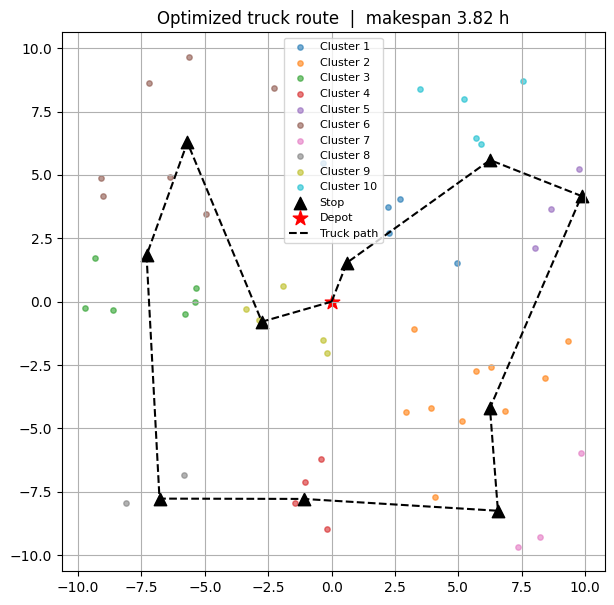


PTD-VRPD finished – makespan 3.82 hours


In [ ]:
# =============================================================
#  PTD-VRPD  ·  static speed profile · cloud-licence Gurobi
#            + Matplotlib plot of the optimized route
# =============================================================

#  pip install gurobipy pyswarm pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist


# -------------------------------------------------------------
# ➜  SET YOUR CLOUD-LICENCE CREDENTIALS  (unchanged)
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()


# -------------------------------------------------------------
# Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed()

AREA_KM             = 10.0
N_DELIVERIES        = 50
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5
BIGM                = 1_000_000.0


# -------------------------------------------------------------
# Speed lookup
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed
speed_func = build_speed_func()


# -------------------------------------------------------------
# Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    return np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any():
                ok=False; break
        if ok: return km.labels_, km.cluster_centers_
        K+=1


# -------------------------------------------------------------
# Integrated MILP builder
# -------------------------------------------------------------
def build_milp(locs, centres, labels):
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV);  m.Params.OutputFlag=0

    r    = m.addVars(nStop,nStop,vtype=GRB.BINARY, name="r")
    Tdep = m.addVars(nStop,lb=0, name="Tdep")
    Tarr = m.addVars(nStop,lb=0, name="Tarr")
    Td   = m.addVars(len(centres),lb=0, name="Tdrone")
    y    = m.addVars(len(custIdx),len(centres),vtype=GRB.BINARY, name="y")

    m.setObjective(
          gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                      for i in range(nStop) for j in range(nStop) if i!=j)
        + gp.quicksum(Td[k] for k in range(len(centres)))
        + SERVICE_MIN_PER_CL/60.*len(centres),
        GRB.MINIMIZE)

    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)

    u = m.addVars(nStop,lb=0,ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)      # depot departure time fixed

    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            m.addConstr(rt - DRONE_END_MIN/60.-BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt * y[cIdx,k])

    return m, r


# -------------------------------------------------------------
# PSO fitness
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    K=len(centres0)
    ctrs = centres0 + w.reshape(K,2)
    # quick reject
    for k,c in enumerate(ctrs):
        d = np.linalg.norm(locs[1:][labels0==k]-c,axis=1)
        rt= 2*d/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
        if (rt>DRONE_END_MIN/60.).any(): return 1e6
    m,_ = build_milp(locs, ctrs, labels0); m.optimize()
    return 1e6 if m.SolCount==0 else m.ObjVal


# -------------------------------------------------------------
# Extract route from r[i,j] binaries
# -------------------------------------------------------------
def extract_route(r_vars):
    # r_vars keys are 2-tuples
    edges = {(i,j) for (i,j),var in r_vars.items() if var.X > 0.5}
    route = [0]
    while len(route) < len(r_vars)**0.5:
        last = route[-1]
        next_stop = next(j for (i,j) in edges if i==last)
        if next_stop==0: break
        route.append(next_stop)
    route.append(0)
    return route


# -------------------------------------------------------------
# Solve instance and plot
# -------------------------------------------------------------
def solve_and_plot(locs):
    labels0, centres0 = kmeans_endurance(locs)
    K  = len(centres0)
    lb = [-2]*2*K;  ub=[2]*2*K

    best_w,best_f = pso(pso_fitness, lb, ub,
                        swarmsize=30, maxiter=15, debug=False,
                        args=(locs, centres0, labels0))

    centres = centres0 if best_f>=1e6 else centres0 + best_w.reshape(K,2)
    mdl,rVars = build_milp(locs, centres, labels0);  mdl.optimize()

    if mdl.SolCount==0:          # fallback (shouldn’t happen)
        centres = centres0
        mdl,rVars = build_milp(locs, centres, labels0); mdl.optimize()

    makespan = np.inf if mdl.SolCount==0 else mdl.ObjVal

    # plot
    route = extract_route(rVars)
    plt.figure(figsize=(7,7))
    # customers
    for k in range(K):
        pts = locs[1:][labels0==k]
        plt.scatter(pts[:,0], pts[:,1], s=15, alpha=0.6, label=f'Cluster {k+1}')
    # centres
    plt.scatter(centres[:,0], centres[:,1], marker='^', c='k', s=80, label='Stop')
    # depot
    plt.scatter(*DEPOT, marker='*', c='red', s=120, label='Depot')
    # truck path
    path_xy = np.vstack([DEPOT, centres])[route]
    plt.plot(path_xy[:,0], path_xy[:,1], 'k--', lw=1.5, label='Truck path')
    plt.title(f'Optimized truck route  |  makespan {makespan:.2f} h')
    plt.legend(loc='best', fontsize=8)
    plt.axis('equal'); plt.grid(True)
    plt.show()

    return makespan


# -------------------------------------------------------------
# Run
# -------------------------------------------------------------
if __name__ == "__main__":
    locs = gen_locations()
    best = solve_and_plot(locs)
    if np.isfinite(best):
        print(f"\nPTD-VRPD finished – makespan {best:.2f} hours")
    else:
        print("\nPTD-VRPD infeasible (unexpected)")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 50 delivery locations.
[DEBUG] K-means found feasible K=7 clusters.
[DEBUG] Starting PSO...
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 4.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 4.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 4.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Particle violated endurance in cluster 5.
[DEBUG][PSO] Particle violated endurance in cluster 4.
[DEBUG][PSO] Particle violated endurance in cluster 0.
[DEBUG][PSO] Pa

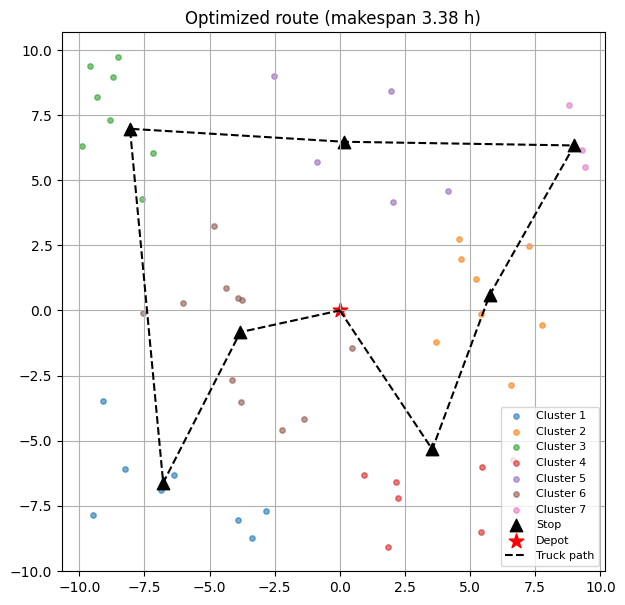


PTD-VRPD finished – makespan 3.38 hours


In [ ]:
# =============================================================
#  PTD-VRPD  ·  static speed profile · cloud-licence Gurobi
#            + debug print statements
# =============================================================

#  pip install gurobipy pyswarm ortools pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0.  Cloud licence credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1.  Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed(RNG_SEED)

AREA_KM             = 10.0
N_DELIVERIES        = 50
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5
BIGM                = 1_000_000.0

# -------------------------------------------------------------
# 2.  Speed lookup
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed

speed_func = build_speed_func()

# -------------------------------------------------------------
# 3.  Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr,axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any():
                ok=False; break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K+=1

# -------------------------------------------------------------
# 4.  Integrated MILP builder
# -------------------------------------------------------------
def build_milp(locs, centres, labels):
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0

    r    = m.addVars(nStop,nStop,vtype=GRB.BINARY, name="r")
    Tdep = m.addVars(nStop,lb=0, name="Tdep")
    Tarr = m.addVars(nStop,lb=0, name="Tarr")
    Td   = m.addVars(len(centres),lb=0, name="Tdrone")
    y    = m.addVars(len(custIdx),len(centres),vtype=GRB.BINARY, name="y")

    m.setObjective(
          gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                      for i in range(nStop) for j in range(nStop) if i!=j)
        + gp.quicksum(Td[k] for k in range(len(centres)))
        + SERVICE_MIN_PER_CL/60.*len(centres),
        GRB.MINIMIZE)

    # routing & subtours
    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)
    u = m.addVars(nStop,lb=0,ub=nStop-1)
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    # timing
    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)

    # assignment & drone endurance
    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            m.addConstr(rt - DRONE_END_MIN/60.-BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt * y[cIdx,k])

    print(f"[DEBUG] Built MILP with {nStop} stops and {len(custIdx)} customers.")
    return m, r

# -------------------------------------------------------------
# 5.  PSO fitness
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    K    = len(centres0)
    ctrs = centres0 + w.reshape(K,2)

    # quick reject & debug
    for k,c in enumerate(ctrs):
        d = np.linalg.norm(locs[1:][labels0==k]-c,axis=1)
        rt= 2*d/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
        if (rt>DRONE_END_MIN/60.).any():
            print(f"[DEBUG][PSO] Particle violated endurance in cluster {k}.")
            return 1e6

    m,_ = build_milp(locs, ctrs, labels0)
    m.optimize()
    if m.SolCount == 0:
        print("[DEBUG][PSO] Particle MILP infeasible.")
        return 1e6

    print(f"[DEBUG][PSO] Particle objective = {m.ObjVal:.2f} h")
    return m.ObjVal

# -------------------------------------------------------------
# 6.  Extract and plot route
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop = int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt = next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted truck route: {route}")
    return route

def plot_solution(locs, centres, labels, route, makespan):
    plt.figure(figsize=(7,7))
    K = len(centres)
    for k in range(K):
        pts=locs[1:][labels==k]
        plt.scatter(pts[:,0],pts[:,1],s=15,alpha=0.6,label=f'Cluster {k+1}')
    plt.scatter(centres[:,0],centres[:,1],marker='^',c='k',s=80,label='Stop')
    plt.scatter(*DEPOT,marker='*',c='red',s=120,label='Depot')
    path_xy=np.vstack([DEPOT,centres])[route]
    plt.plot(path_xy[:,0],path_xy[:,1],'k--',lw=1.5,label='Truck path')
    plt.title(f'Optimized route (makespan {makespan:.2f} h)')
    plt.legend(fontsize=8); plt.axis('equal'); plt.grid(True)
    plt.show()

# -------------------------------------------------------------
# 7.  Solve & plot in one go
# -------------------------------------------------------------
def solve_and_plot(locs):
    labels0, centres0 = kmeans_endurance(locs)
    K  = len(centres0)
    lb = [-2]*2*K; ub=[2]*2*K

    print("[DEBUG] Starting PSO...")
    best_w, best_f = pso(pso_fitness, lb, ub,
                        swarmsize=30, maxiter=15, debug=False,
                        args=(locs, centres0, labels0))
    print(f"[DEBUG] PSO completed: best_f = {best_f:.2f}")

    centres = centres0 if best_f>=1e6 else centres0 + best_w.reshape(K,2)
    print(f"[DEBUG] Using centres:\n{centres}")

    mdl, rVars = build_milp(locs, centres, labels0)
    mdl.optimize()
    if mdl.SolCount==0:
        print("[DEBUG] Final MILP infeasible, falling back to raw centres.")
        centres = centres0
        mdl, rVars = build_milp(locs, centres, labels0)
        mdl.optimize()

    makespan = np.inf if mdl.SolCount==0 else mdl.ObjVal
    route    = extract_route(rVars)
    plot_solution(locs, centres, labels0, route, makespan)
    return makespan

# -------------------------------------------------------------
# 8.  Demo run
# -------------------------------------------------------------
if __name__=="__main__":
    locs = gen_locations()
    best = solve_and_plot(locs)
    if np.isfinite(best):
        print(f"\nPTD-VRPD finished – makespan {best:.2f} hours")
    else:
        print("\nPTD-VRPD infeasible (unexpected)")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 50 delivery locations.
[DEBUG] K-means found feasible K=7 clusters.
[DEBUG] Starting PSO...
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 4.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 4.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 4.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Particle violates endurance at cluster 5.
[DEBUG][PSO] Particle violates endurance at cluster 4.
[DEBUG][PSO] Particle violates endurance at cluster 0.
[DEBUG][PSO] Pa

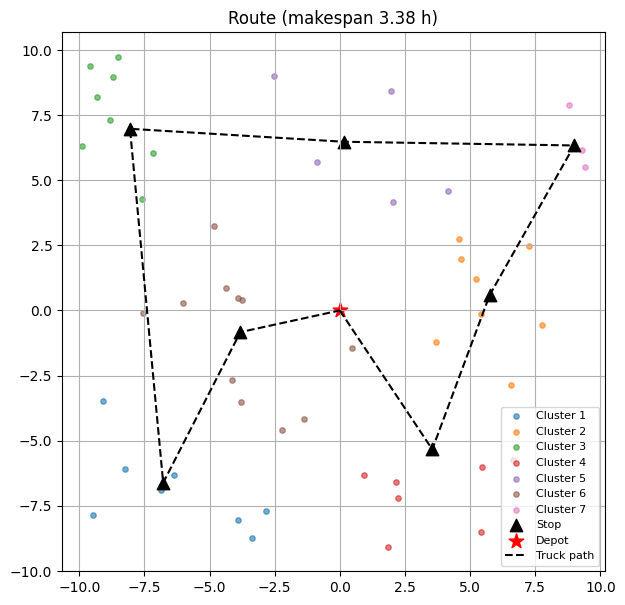


PTD-VRPD finished – makespan 3.38 hours


In [ ]:
# =============================================================
#  PTD-VRPD  ·  static speed profile · cloud-licence Gurobi
#            + per-MILP debug: truck/drone/service/total times
# =============================================================

#  pip install gurobipy pyswarm ortools pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0. Cloud licence credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1. Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed(RNG_SEED)

AREA_KM             = 10.0
N_DELIVERIES        = 50
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5
BIGM                = 1_000_000.0

# -------------------------------------------------------------
# 2. Speed lookup
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' and 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed
speed_func = build_speed_func()

# -------------------------------------------------------------
# 3. Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any():
                ok=False; break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K+=1

# -------------------------------------------------------------
# 4. Build & solve MILP, with debug prints
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    """
    Builds and solves the MILP, then prints truck/drone/service/total times.
    Returns (model, rVars).
    """
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0

    r    = m.addVars(nStop,nStop, vtype=GRB.BINARY, name="r")
    Tdep = m.addVars(nStop, lb=0, name="Tdep")
    Tarr = m.addVars(nStop, lb=0, name="Tarr")
    Td   = m.addVars(len(centres), lb=0, name="Tdrone")
    y    = m.addVars(len(custIdx), len(centres), vtype=GRB.BINARY, name="y")

    # Objective
    m.setObjective(
        gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                    for i in range(nStop) for j in range(nStop) if i!=j)
      + gp.quicksum(Td[k] for k in range(len(centres)))
      + SERVICE_MIN_PER_CL/60.*len(centres),
      GRB.MINIMIZE)

    # Routing & subtours
    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)
    u = m.addVars(nStop, lb=0, ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    # Timing
    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)

    # Drone assignment & endurance
    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            m.addConstr(rt - DRONE_END_MIN/60. - BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt * y[cIdx,k])

    # Solve
    m.optimize()
    if m.SolCount == 0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return m, r

    # Compute times
    truck_time  = sum((Dman[i,j]/speed_func(0)) * r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time  = sum(Td[k].X for k in range(len(centres)))
    service_time= SERVICE_MIN_PER_CL/60.*len(centres)
    total_time  = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"        Truck time:  {truck_time:.3f} h")
    print(f"        Drone time:  {drone_time:.3f} h")
    print(f"        Service time:{service_time:.3f} h")
    print(f"        Total time:  {total_time:.3f} h  (ObjVal {m.ObjVal:.3f})")
    return m, r

# -------------------------------------------------------------
# 5. PSO fitness
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    K    = len(centres0)
    ctrs = centres0 + w.reshape(K,2)

    # quick reject
    for k,c in enumerate(ctrs):
        d = np.linalg.norm(locs[1:][labels0==k]-c,axis=1)
        rt= 2*d/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
        if (rt>DRONE_END_MIN/60.).any():
            print(f"[DEBUG][PSO] Particle violates endurance at cluster {k}.")
            return 1e6

    m,r = build_and_solve_milp(locs, ctrs, labels0, tag="[PSO]")
    return 1e6 if m.SolCount==0 else m.ObjVal

# -------------------------------------------------------------
# 6. Extract route helper
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop = int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt = next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7. Solve & plot
# -------------------------------------------------------------
def solve_and_plot(locs):
    labels0, centres0 = kmeans_endurance(locs)
    K  = len(centres0)
    lb = [-2]*2*K; ub=[2]*2*K

    print("[DEBUG] Starting PSO...")
    best_w, best_f = pso(pso_fitness, lb, ub,
                        swarmsize=30, maxiter=15, debug=False,
                        args=(locs, centres0, labels0))
    print(f"[DEBUG] PSO best_f = {best_f:.3f}")

    centres = centres0 if best_f>=1e6 else centres0 + best_w.reshape(K,2)
    mdl, rVars = build_and_solve_milp(locs, centres, labels0, tag="[FINAL]")
    if mdl.SolCount==0:
        print("[DEBUG] FINAL MILP infeasible, falling back.")
        centres = centres0
        mdl, rVars = build_and_solve_milp(locs, centres, labels0, tag="[FALLBACK]")

    route = extract_route(rVars)

    # Plot
    plt.figure(figsize=(7,7))
    for k in range(len(centres)):
        pts=locs[1:][labels0==k]
        plt.scatter(pts[:,0],pts[:,1],s=15,alpha=0.6,label=f'Cluster {k+1}')
    plt.scatter(centres[:,0],centres[:,1],marker='^',c='k',s=80,label='Stop')
    plt.scatter(*DEPOT,marker='*',c='red',s=120,label='Depot')
    path_xy=np.vstack([DEPOT,centres])[route]
    plt.plot(path_xy[:,0],path_xy[:,1],'k--',lw=1.5,label='Truck path')
    plt.title(f'Route (makespan {mdl.ObjVal:.2f} h)')
    plt.legend(fontsize=8); plt.axis('equal'); plt.grid(True)
    plt.show()

    return mdl.ObjVal

# -------------------------------------------------------------
# 8. Demo run
# -------------------------------------------------------------
if __name__=="__main__":
    locs = gen_locations()
    best = solve_and_plot(locs)
    if np.isfinite(best):
        print(f"\nPTD-VRPD finished – makespan {best:.2f} hours")
    else:
        print("\nPTD-VRPD infeasible (unexpected)")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 50 delivery locations.
[DEBUG] K-means found feasible K=8 clusters.
[DEBUG] Beginning PSO...
[DEBUG][PSO] Starting iteration 1
[DEBUG][PSO] Iter 1 P1 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P2 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P3 → endurance VIOLATION in cluster 1
[DEBUG][PSO] Iter 1 P4 → endurance VIOLATION in cluster 3
[DEBUG][PSO] Iter 1 P5 → endurance VIOLATION in cluster 5
[DEBUG][PSO] Iter 1 P6 → endurance VIOLATION in cluster 1
[DEBUG][PSO] Iter 1 P7 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P8 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P9 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P10 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P11 → endurance VIOLATION in cluster 1
[DEBUG][PSO] Iter 1 P12 → endurance VIOLATION in cluster 0
[DEBUG][PSO] Iter 1 P13 → endurance VIOLATION in cl

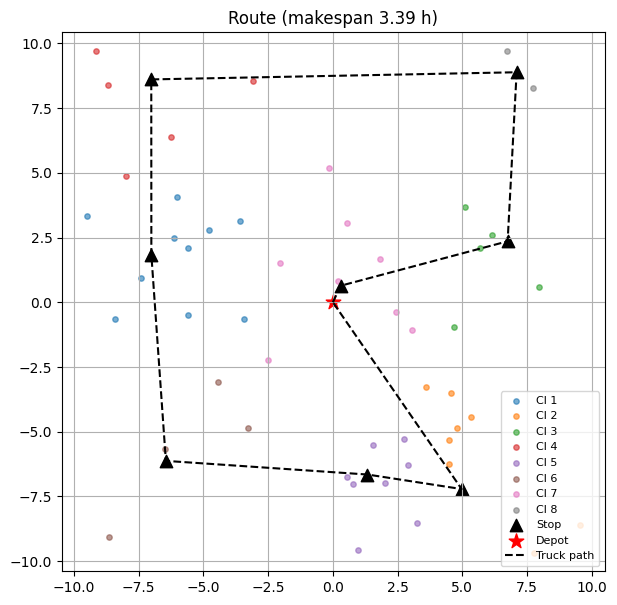


PTD-VRPD finished – makespan 3.39 hours


In [ ]:
# =============================================================
#  PTD-VRPD  ·  static speed profile · cloud-licence Gurobi
#            + PSO iteration & particle debug
# =============================================================

# pip install gurobipy pyswarm ortools pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0. Cloud licence credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1. Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed()

AREA_KM             = 10.0
N_DELIVERIES        = 50
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5
BIGM                = 1_000_000.0

# PSO iteration & particle tracking
SWARM_SIZE   = 30
ITERATIONS  = 15
call_counter = 0
iter_counter = 0

# -------------------------------------------------------------
# 2. Speed lookup
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed
speed_func = build_speed_func()

# -------------------------------------------------------------
# 3. Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any():
                ok=False; break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K+=1

# -------------------------------------------------------------
# 4. Build & solve MILP with debug
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0

    r    = m.addVars(nStop,nStop, vtype=GRB.BINARY, name="r")
    Tdep = m.addVars(nStop, lb=0, name="Tdep")
    Tarr = m.addVars(nStop, lb=0, name="Tarr")
    Td   = m.addVars(len(centres), lb=0, name="Tdrone")
    y    = m.addVars(len(custIdx), len(centres), vtype=GRB.BINARY, name="y")

    # Objective
    m.setObjective(
        gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                    for i in range(nStop) for j in range(nStop) if i!=j)
      + gp.quicksum(Td[k] for k in range(len(centres)))
      + SERVICE_MIN_PER_CL/60.*len(centres),
      GRB.MINIMIZE)

    # Routing & subtours
    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)
    u = m.addVars(nStop, lb=0, ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    # Timing
    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)

    # Drone assignment & endurance
    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            m.addConstr(rt - DRONE_END_MIN/60.-BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt * y[cIdx,k])

    # Solve
    m.optimize()
    if m.SolCount == 0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return m, r

    # Compute and print component times
    truck_time  = sum((Dman[i,j]/speed_func(0)) * r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time  = sum(Td[k].X for k in range(len(centres)))
    service_time= SERVICE_MIN_PER_CL/60.*len(centres)
    total_time  = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"   → Truck time   = {truck_time:.3f} h")
    print(f"   → Drone time   = {drone_time:.3f} h")
    print(f"   → Service time = {service_time:.3f} h")
    print(f"   → Total time   = {total_time:.3f} h (Obj {m.ObjVal:.3f})")
    return m, r

# -------------------------------------------------------------
# 5. PSO fitness with iteration + particle debug
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    global call_counter, iter_counter
    call_counter += 1
    if call_counter % SWARM_SIZE == 1:
        iter_counter += 1
        print(f"[DEBUG][PSO] Starting iteration {iter_counter}")

    particle_idx = ((call_counter-1) % SWARM_SIZE) + 1
    K    = len(centres0)
    ctrs = centres0 + w.reshape(K,2)

    # quick reject
    for k,c in enumerate(ctrs):
        d = np.linalg.norm(locs[1:][labels0==k]-c,axis=1)
        rt= 2*d/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
        if (rt>DRONE_END_MIN/60.).any():
            print(f"[DEBUG][PSO] Iter {iter_counter} P{particle_idx} → endurance VIOLATION in cluster {k}")
            return 1e6

    # passes endurance
    print(f"[DEBUG][PSO] Iter {iter_counter} P{particle_idx} → endurance OK, centres =\n{ctrs}")

    m,r = build_and_solve_milp(locs, ctrs, labels0, tag=f"[PSO it{iter_counter} p{particle_idx}]")
    return 1e6 if m.SolCount==0 else m.ObjVal

# -------------------------------------------------------------
# 6. Extract route helper
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop=int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt = next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7. Solve & plot
# -------------------------------------------------------------
def solve_and_plot(locs):
    global call_counter, iter_counter
    call_counter, iter_counter = 0, 0

    labels0, centres0 = kmeans_endurance(locs)
    lb = [-2]*2*len(centres0)
    ub = [ 2]*2*len(centres0)

    print("[DEBUG] Beginning PSO...")
    best_w, best_f = pso(pso_fitness, lb, ub,
                         swarmsize=SWARM_SIZE, maxiter=ITERATIONS, debug=False,
                         args=(locs, centres0, labels0))
    print(f"[DEBUG] PSO completed: best_f = {best_f:.3f}")

    centres = centres0 if best_f>=1e6 else centres0 + best_w.reshape(len(centres0),2)
    mdl, rVars = build_and_solve_milp(locs, centres, labels0, tag="[FINAL]")
    if mdl.SolCount==0:
        print("[DEBUG] FINAL infeasible, fallback.")
        centres = centres0
        mdl, rVars = build_and_solve_milp(locs, centres, labels0, tag="[FALLBACK]")

    route = extract_route(rVars)

    # plot
    plt.figure(figsize=(7,7))
    for k in range(len(centres)):
        pts=locs[1:][labels0==k]
        plt.scatter(pts[:,0],pts[:,1],s=15,alpha=0.6,label=f'Cl {k+1}')
    plt.scatter(centres[:,0],centres[:,1],
                marker='^',c='k',s=80,label='Stop')
    plt.scatter(*DEPOT,marker='*',c='r',s=120,label='Depot')
    path_xy=np.vstack([DEPOT,centres])[route]
    plt.plot(path_xy[:,0],path_xy[:,1],'k--',lw=1.5,label='Truck path')
    plt.title(f'Route (makespan {mdl.ObjVal:.2f} h)')
    plt.legend(fontsize=8); plt.axis('equal'); plt.grid(True)
    plt.show()

    return mdl.ObjVal

# -------------------------------------------------------------
# 8. Demo
# -------------------------------------------------------------
if __name__=="__main__":
    locs = gen_locations()
    best = solve_and_plot(locs)
    if np.isfinite(best):
        print(f"\nPTD-VRPD finished – makespan {best:.2f} hours")
    else:
        print("\nPTD-VRPD infeasible (unexpected)")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 100 delivery locations.
[DEBUG] K-means found feasible K=10 clusters.
[DEBUG][CLUSTER] MILP solved:
   → Truck   1.092 h | Drone 1.792 h | Service 0.833 h | Total 3.718 h
[DEBUG] Beginning PSO optimisation...
[DEBUG][PSO] it 0 p1: centres OK
[DEBUG][PSO it0 p1] MILP solved:
   → Truck   1.232 h | Drone 1.697 h | Service 0.833 h | Total 3.762 h
[DEBUG][PSO] it 0 p2: centres OK
[DEBUG][PSO it0 p2] MILP solved:
   → Truck   1.133 h | Drone 1.778 h | Service 0.833 h | Total 3.745 h
[DEBUG][PSO] it 0 p3: centres OK
[DEBUG][PSO it0 p3] MILP solved:
   → Truck   1.244 h | Drone 1.715 h | Service 0.833 h | Total 3.792 h
[DEBUG][PSO] it 0 p4: centres OK
[DEBUG][PSO it0 p4] MILP solved:
   → Truck   1.157 h | Drone 1.504 h | Service 0.833 h | Total 3.495 h
[DEBUG][PSO] it 0 p5: centres OK
[DEBUG][PSO it0 p5] MILP solved:
   → Truck   1.231 h | Drone 1.709 h | Service 0.833 h

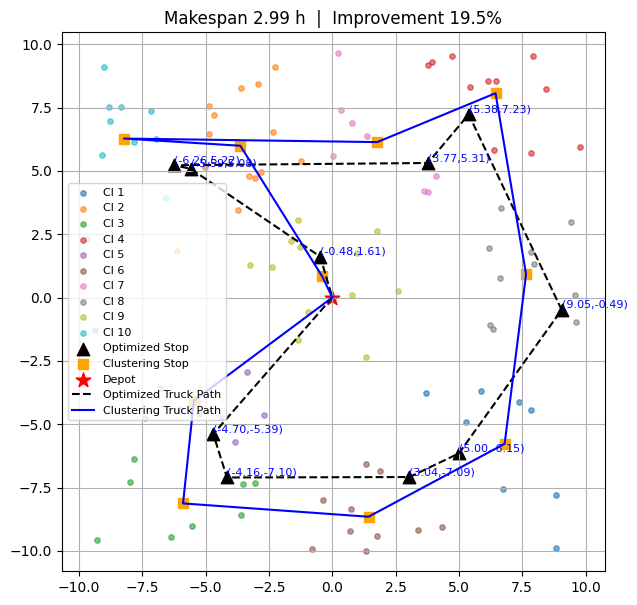


PTD-VRPD finished – baseline 3.72 h, optimised 2.99 h,  Δ = 19.5%


In [ ]:
# =============================================================
#  PTD-VRPD  ·  static speed profile · cloud-licence Gurobi
#            baseline (clustering) vs. optimised (PSO) comparison
# =============================================================

#  pip install gurobipy pyswarm pandas numpy scikit-learn matplotlib

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from   sklearn.cluster       import KMeans
from   pyswarm               import pso
import gurobipy as gp
from   gurobipy              import GRB
from   scipy.interpolate      import interp1d
from   scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0.  Cloud-licence credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395
def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env
GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1.  Global constants
# -------------------------------------------------------------
RNG_SEED            = 42
np.random.seed()

AREA_KM             = 10.0
N_DELIVERIES        = 100
DEPOT               = (0., 0.)

DRONE_SPEED_KMH     = 40.
DRONE_END_MIN       = 20
SERVICE_MIN_PER_CL  = 5
BIGM                = 1_000_000.0

# PSO bookkeeping
SWARM_SIZE   = 100
ITERATIONS  = 15
call_counter = 0
iter_counter = 0

# -------------------------------------------------------------
# 2.  Speed lookup
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f  = interp1d(df["Time of Day"]%24, df["Predicted Speed"],
                  kind="linear", fill_value="extrapolate")
    def speed(t): return float(f(t%24))
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {speed(9.5):.1f} km/h")
    return speed
speed_func = build_speed_func()

# -------------------------------------------------------------
# 3.  Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT, np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K=1
    while True:
        km = KMeans(n_clusters=K, random_state=RNG_SEED, n_init=10).fit(locs[1:])
        ok=True
        for i,ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i]-ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.
            if (rt>DRONE_END_MIN/60.).any():
                ok=False; break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K+=1

# -------------------------------------------------------------
# 4.  Build & solve MILP (with component-time debug)
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    nStop   = len(centres)+1
    custIdx = np.arange(1,len(locs))

    xy   = np.vstack([DEPOT, centres])
    Dman = cdist(xy,xy,metric="cityblock")
    Deuc = cdist(locs,xy)

    m = gp.Model(env=GRB_ENV); m.Params.OutputFlag=0

    ############################
    # decision variables
    ############################
    r    = m.addVars(nStop,nStop,vtype=GRB.BINARY,name="r") # routing
    Tdep = m.addVars(nStop,lb=0,name="Tdep") # departure times
    Tarr = m.addVars(nStop,lb=0,name="Tarr") # arrival times
    Td   = m.addVars(len(centres),lb=0,name="Tdrone") # drone times
    y    = m.addVars(len(custIdx),len(centres),vtype=GRB.BINARY,name="y") # drone assignment
    
    ##########################
    # objective
    ##########################
    m.setObjective(
        gp.quicksum(Dman[i,j]/speed_func(0)*r[i,j]
                    for i in range(nStop) for j in range(nStop) if i!=j)
    + gp.quicksum(Td[k] for k in range(len(centres)))
    + SERVICE_MIN_PER_CL/60.*len(centres),
    GRB.MINIMIZE)

    ##########################
    # constraints
    ##########################
    # routing & subtour elimination 
    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i)==1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i)==1)
    u = m.addVars(nStop,lb=0,ub=nStop-1)
    for i,j in itertools.permutations(range(1,nStop),2):
        m.addConstr(u[i]-u[j]+(nStop-1)*r[i,j] <= nStop-2)

    # timing constraints
    for i,j in itertools.product(range(nStop),range(nStop)):
        if i==j: continue
        m.addConstr(Tarr[j] >= Tdep[i] + Dman[i,j]/speed_func(0)
                    - BIGM*(1-r[i,j]))
        if i!=0:
            m.addConstr(Tdep[i] >= Tarr[i] + Td[i-1] + SERVICE_MIN_PER_CL/60.)
    m.addConstr(Tdep[0]==0)

    # drone assignment & endurance constraints
    for cIdx,cust in enumerate(custIdx):
        m.addConstr(gp.quicksum(y[cIdx,k] for k in range(len(centres)))==1)
        for k in range(len(centres)):
            rt = 2*Deuc[cust,k+1]/DRONE_SPEED_KMH
            m.addConstr(rt - DRONE_END_MIN/60. - BIGM*(1-y[cIdx,k]) <= 0)
            m.addConstr(Td[k] >= rt*y[cIdx,k])

    m.optimize()
    if m.SolCount==0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return np.inf, m, r

    # component times 
    truck_time  = sum((Dman[i,j]/speed_func(0))*r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time  = sum(Td[k].X for k in range(len(centres)))
    service_time= SERVICE_MIN_PER_CL/60.*len(centres)
    total_time  = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"   → Truck   {truck_time:.3f} h | Drone {drone_time:.3f} h | "
          f"Service {service_time:.3f} h | Total {total_time:.3f} h")
    return total_time, m, r

# -------------------------------------------------------------
# 5.  PSO fitness with iteration/particle debug
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    global call_counter, iter_counter
    call_counter += 1

    # Once we've seen SWARM_SIZE evaluations, that's the end of iteration 1, etc.
    if call_counter % SWARM_SIZE == 0:
        iteration = call_counter // SWARM_SIZE
        if 1 <= iteration <= ITERATIONS:
            iter_counter = iteration
            print(f"[DEBUG][PSO] -------------------- iteration {iter_counter} ---------------------")

    particle_idx = ((call_counter - 1) % SWARM_SIZE) + 1
    K = len(centres0)
    ctrs = centres0 + w.reshape(K, 2)

    # endurance check
    for k, c in enumerate(ctrs):
        d  = np.linalg.norm(locs[1:][labels0 == k] - c, axis=1)
        rt = 2 * d / DRONE_SPEED_KMH
        if (rt > DRONE_END_MIN / 60.).any():
            print(f"[DEBUG][PSO] it {iter_counter} p{particle_idx}: endurance VIOLATION in cl {k}")
            return 1e6

    print(f"[DEBUG][PSO] it {iter_counter} p{particle_idx}: centres OK")
    obj, _, _ = build_and_solve_milp(
        locs, ctrs, labels0,
        tag=f"[PSO it{iter_counter} p{particle_idx}]"
    )
    return 1e6 if np.isinf(obj) else obj 

# -------------------------------------------------------------
# 6.  Route extractor
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]; nStop=int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt = next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7.  Main solver/plotter
# -------------------------------------------------------------
def solve_and_plot(locs):
    global call_counter, iter_counter
    call_counter = iter_counter = 0

    labels0, centres0 = kmeans_endurance(locs)

    # -------- baseline (clustering only) --------------------
    base_time, base_mdl, base_r = build_and_solve_milp(
        locs, centres0, labels0, tag="[CLUSTER]")
    if np.isinf(base_time):
        raise RuntimeError("Baseline clustering model infeasible — should not happen")

    # -------- optimised (PSO) -------------------------------
    lb = [-2]*2*len(centres0); ub = [2]*2*len(centres0)
    print("[DEBUG] Beginning PSO optimisation...")
    w_best, f_best = pso(pso_fitness, lb, ub,
                         swarmsize=SWARM_SIZE, maxiter=ITERATIONS, debug=False,
                         args=(locs, centres0, labels0))
    print(f"[DEBUG] PSO best objective = {f_best:.3f} h")
    print(f"[DEBUG] PSO best weights =\n{w_best}")
    print(f"[DEBUG] PSO best centres =\n{centres0 + w_best.reshape(len(centres0),2)}")

    centres_opt = centres0 if f_best>=1e6 else centres0 + w_best.reshape(len(centres0),2) # If infeasible, fallback to clustering centre
    opt_time, opt_mdl, opt_r = build_and_solve_milp(locs, centres_opt, labels0, tag="[OPT ]")
    if np.isinf(opt_time):
        # fallback to baseline if somehow infeasible
        centres_opt, opt_time, opt_r = centres0, base_time, base_r

    # -------- improvement ----------------------------------
    improvement = 100*(base_time - opt_time)/base_time
    print(f"\n[RESULT] Clustering   : {base_time:.3f} h")
    print(f"[RESULT] Optimised    : {opt_time:.3f} h")
    print(f"[RESULT] Improvement  : {improvement:.2f} %")

    # -------- plot (optimised) ------------------------------
    route_opt = extract_route(opt_r)
    route_base = extract_route(base_r)
    plt.figure(figsize=(7,7))
    for k in range(len(centres0)):
        pts = locs[1:][labels0==k]
        plt.scatter(pts[:,0],pts[:,1],s=15,alpha=0.6,label=f'Cl {k+1}')
    plt.scatter(centres_opt[:,0],centres_opt[:,1],marker='^',c='k',s=80,label='Optimized Stop')
    plt.scatter(centres0[:,0],centres0[:,1],marker='s',c='orange',s=60,label='Clustering Stop')
    plt.scatter(*DEPOT,marker='*',c='r',s=120,label='Depot')
    # Plot optimized route
    path_xy_opt = np.vstack([DEPOT, centres_opt])[route_opt]
    plt.plot(path_xy_opt[:,0],path_xy_opt[:,1],'k--',lw=1.5,label='Optimized Truck Path')
    # Plot clustering (baseline) route
    path_xy_base = np.vstack([DEPOT, centres0])[route_base]
    plt.plot(path_xy_base[:,0],path_xy_base[:,1],'b-',lw=1.5,label='Clustering Truck Path')
    plt.title(f'Makespan {opt_time:.2f} h  |  Improvement {improvement:.1f}%')
    plt.legend(fontsize=8); plt.axis('equal'); plt.grid(True)

    # Plot the values of the PSO best centers beside each center
    for idx, (x, y) in enumerate(centres_opt):
        plt.text(x, y, f'({x:.2f},{y:.2f})', fontsize=8, color='blue', ha='left', va='bottom')

    plt.show()

    return base_time, opt_time, improvement

# -------------------------------------------------------------
# 8.  Demo run
# -------------------------------------------------------------
if __name__=="__main__":
    locs               = gen_locations()
    base, opt, impr    = solve_and_plot(locs)
    print(f"\nPTD-VRPD finished – baseline {base:.2f} h, "
          f"optimised {opt:.2f} h,  Δ = {impr:.1f}%")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 50 delivery locations.
[DEBUG] K-means found feasible K=7 clusters.
[DEBUG][CLUSTER] MILP solved:
   → Truck   0.980 h | Drone 1.244 h | Service 0.583 h | Total  2.808 h
[DEBUG] Starting PSO…
[DEBUG][PSO] it0 p1: centres OK
[DEBUG][PSO it0 p1] MILP solved:
   → Truck   1.035 h | Drone 1.360 h | Service 0.583 h | Total  2.978 h
[DEBUG][PSO] it0 p2: centres OK
[DEBUG][PSO it0 p2] MILP solved:
   → Truck   0.946 h | Drone 1.300 h | Service 0.583 h | Total  2.830 h
[DEBUG][PSO] it0 p3: centres OK
[DEBUG][PSO it0 p3] MILP solved:
   → Truck   1.105 h | Drone 1.513 h | Service 0.583 h | Total  3.202 h
[DEBUG][PSO] it0 p4: centres OK
[DEBUG][PSO it0 p4] MILP solved:
   → Truck   1.011 h | Drone 1.471 h | Service 0.583 h | Total  3.066 h
[DEBUG][PSO] it0 p5: centres OK
[DEBUG][PSO it0 p5] MILP solved:
   → Truck   0.941 h | Drone 1.357 h | Service 0.583 h | Total  2.881 h


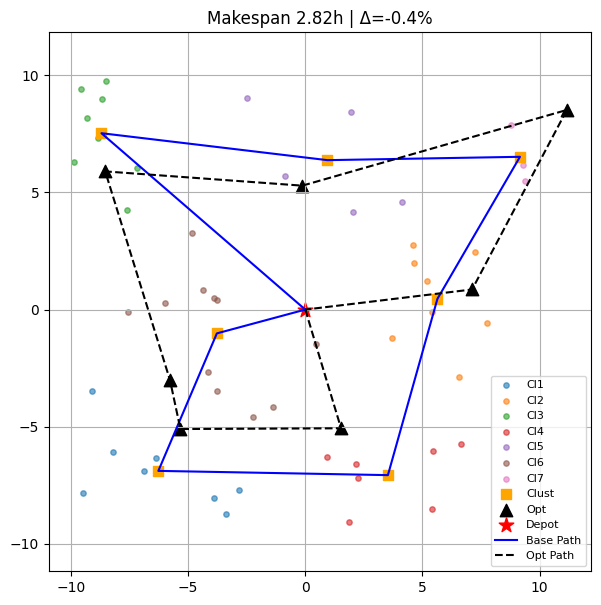


Done – baseline 2.81h, optimized 2.82h, Δ=-0.4%


In [ ]:
# =============================================================
#  PTD-VRPD  ·  time‐dependent speed profile · cloud Gurobi
#            baseline vs. optimized (PSO)
# =============================================================

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pyswarm import pso
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0.  Cloud‐license credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395

def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env

GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1.  Global constants
# -------------------------------------------------------------
RNG_SEED           = 42
np.random.seed(RNG_SEED)

AREA_KM            = 10.0
N_DELIVERIES       = 50
DEPOT              = (0.0, 0.0)

DRONE_SPEED_KMH    = 40.0
DRONE_END_MIN      = 20
SERVICE_MIN_PER_CL = 5.0
BIGM               = 1e6

SWARM_SIZE   = 10
ITERATIONS   = 1
call_counter = 0
iter_counter = 0

BANDS      = np.arange(0, 24 + 0.25, 0.25)
SPEED_BAND = None
START_TIME = 8.0  # Start time for delivery process

# -------------------------------------------------------------
# 2.  Speed lookup + precompute per‐band speeds
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f = interp1d(df["Time of Day"] % 24,
                  df["Predicted Speed"],
                  kind="linear",
                  fill_value="extrapolate")
    global SPEED_BAND
    SPEED_BAND = f(BANDS)
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {f(9.5):.1f} km/h")
    return lambda t: float(f(t % 24))

speed_func = build_speed_func()

# -------------------------------------------------------------
# 3.  Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT,
                      np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K = 1
    while True:
        km = KMeans(n_clusters=K,
                    random_state=RNG_SEED,
                    n_init=10).fit(locs[1:])
        ok = True
        for i, ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i] - ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.0
            if (rt > DRONE_END_MIN/60.0).any():
                ok = False
                break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K += 1

# -------------------------------------------------------------
# 4.  Build & solve MILP (with PWL + correct endurance)
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    """
    Builds and solves the time-dependent truck–drone MILP.
    Enforces:
      • Time‐dependent truck travel via PWL on Tdep → TT
      • Arrival→departure chaining: Tarr→Tdep ≥ Tarr + service + drone‐time
      • Drone‐endurance and dynamic Td = sum of assigned round‐trips
      • Standard MTZ subtour‐elimination for routing
    """
    # Number of stops = depot + each truck‐stop center
    nStop   = len(centres) + 1
    custIdx = np.arange(1, len(locs))  # indices of customer points

    # Precompute distance matrices
    xy   = np.vstack([DEPOT, centres])  # points for routing (depot + stops)
    Dman = cdist(xy, xy, metric="cityblock")
    Deuc = cdist(locs, xy)              # for drone endurance

    # Create Gurobi model
    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0

    # === Decision variables ===
    # r[i,j] = 1 if truck goes directly from i to j
    r    = m.addVars(nStop, nStop, vtype=GRB.BINARY, name="r")
    # Tdep[i], Tarr[i] = departure/arrival times at stop i
    Tdep = m.addVars(nStop, lb=0.0, name="Tdep")
    Tarr = m.addVars(nStop, lb=0.0, name="Tarr")
    # TT[i,j] = travel time from i to j (time‐dependent)
    TT   = m.addVars(nStop, nStop, lb=0.0, name="TT")
    # Td[k] = total drone operation time at cluster k (k=0..len(centres)-1)
    Td   = m.addVars(len(centres), lb=0.0, name="Tdrone")
    # y[cIdx,k] = 1 if customer cIdx is served by drone at cluster k
    y    = m.addVars(len(custIdx), len(centres),
                     vtype=GRB.BINARY, name="y")

    # === Objective ===
    # Minimize total makespan = truck travel + drone times + service blocks
    m.setObjective(
        gp.quicksum(TT[i,j] * r[i,j]
                    for i in range(nStop) for j in range(nStop) if i != j)
      + gp.quicksum(Td[k] for k in range(len(centres)))
      + SERVICE_MIN_PER_CL/60.0 * len(centres),
      GRB.MINIMIZE)

    # === Routing & MTZ subtour elimination ===
    for i in range(nStop):
        # exactly one outbound and one inbound per node
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i) == 1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i) == 1)
    # MTZ variables
    u = m.addVars(nStop, lb=0.0, ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop), 2):
        m.addConstr(u[i] - u[j] + (nStop-1)*r[i,j] <= nStop-2)

    # === Time‐dependent travel via PWL + link Tarr ← Tdep + TT ===

    # --- 1. one PWL for invSpeed per stop ---
    inv_min = float(np.min(1/SPEED_BAND))
    inv_max = float(np.max(1/SPEED_BAND))
    invSpd = m.addVars(nStop, lb=inv_min, ub=inv_max, name="invSpd")
    for i in range(nStop):
        inv_vals = (1 / SPEED_BAND).tolist()              # same 96 break-points
        m.addGenConstrPWL(Tdep[i], invSpd[i],
                        BANDS.tolist(), inv_vals,
                        name=f"invPWL_{i}")

    # --- 2. TT[i,j] becomes linear in invSpd[i] ---
    for i in range(nStop):
        for j in range(nStop):
            if i == j: continue
            m.addConstr(
                TT[i,j] == Dman[i,j] * invSpd[i],
                name=f"TTdef_{i}_{j}"
            )
            m.addConstr(
                Tarr[j] >= Tdep[i] + TT[i,j] - BIGM*(1 - r[i,j]),
                name=f"timelink_{i}_{j}"
            )
    # truck starts at time 0
    m.addConstr(Tdep[0] == START_TIME)

    # === Departure chaining: wait for arrival + service + drones ===
    for i in range(1, nStop):
        # Td[i-1] is the drone‐block time for cluster i
        m.addConstr(
            Tdep[i]
            >= Tarr[i]
               + SERVICE_MIN_PER_CL/60.0
               + Td[i-1],
            name=f"wait_after_stop_{i}"
        )

    # === Drone assignment & endurance constraints ===
    for cIdx, cust in enumerate(custIdx):
        # Each customer must be served by exactly one drone/cluster
        m.addConstr(
            gp.quicksum(y[cIdx,k] for k in range(len(centres))) == 1,
            name=f"assignCust_{cIdx}"
        )
        for k in range(len(centres)):
            # round-trip time to that cluster
            rt = 2 * Deuc[cust, k+1] / DRONE_SPEED_KMH
            # endurance big-M: if y=1 then rt <= endurance
            m.addConstr(
                gp.LinExpr(rt - DRONE_END_MIN/60.0)
                <= BIGM * (1 - y[cIdx,k]),
                name=f"endurance_{cIdx}_{k}"
            )
            # accumulate drone times: Td[k] >= sum of all rt * y
            # we generate one constraint per (cust,k),
            # and the solver will push Td to the sum automatically.
            m.addConstr(
                Td[k] >= rt * y[cIdx,k],
                name=f"droneTime_{cIdx}_{k}"
            )

    # === Solve ===
    m.optimize()
    if m.SolCount == 0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return np.inf, m, r

    # === Extract objective components ===
    truck_time   = sum(TT[i,j].X * r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time   = sum(Td[k].X for k in range(len(centres)))
    service_time = SERVICE_MIN_PER_CL/60.0 * len(centres)
    total_time   = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"   → Truck   {truck_time:.3f} h | "
          f"Drone {drone_time:.3f} h | "
          f"Service {service_time:.3f} h | "
          f"Total  {total_time:.3f} h")
    return total_time, m, r

# -------------------------------------------------------------
# 5.  PSO fitness …
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    global call_counter, iter_counter
    call_counter += 1
    if call_counter % SWARM_SIZE == 0:
        iteration = call_counter // SWARM_SIZE
        if 1 <= iteration <= ITERATIONS:
            iter_counter = iteration
            print(f"[DEBUG][PSO] -- iter {iter_counter} --")

    particle_idx = ((call_counter - 1) % SWARM_SIZE) + 1
    K = len(centres0)
    ctrs = centres0 + w.reshape(K, 2)

    # endurance check (pre-MILP)
    for k, c in enumerate(ctrs):
        d  = np.linalg.norm(locs[1:][labels0==k] - c, axis=1)
        rt = 2 * d / DRONE_SPEED_KMH
        if (rt > DRONE_END_MIN/60.0).any():
            print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: "
                  f"endurance VIOLATION in cl {k}")
            return 1e6

    print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: centres OK")
    obj, _, _ = build_and_solve_milp(
        locs, ctrs, labels0,
        tag=f"[PSO it{iter_counter} p{particle_idx}]"
    )
    return 1e6 if np.isinf(obj) else obj

# -------------------------------------------------------------
# 6.  Extract route from r-vars
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop=int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt=next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7.  Main solver + plot
# -------------------------------------------------------------

def solve_and_plot(locs):
    global call_counter, iter_counter
    call_counter = iter_counter = 0

    labels0, centres0 = kmeans_endurance(locs)

    base_time, base_mdl, base_r = build_and_solve_milp(
        locs, centres0, labels0, tag="[CLUSTER]")
    if np.isinf(base_time):
        raise RuntimeError("Baseline infeasible")

    lb = [-2]*2*len(centres0)
    ub = [ 2]*2*len(centres0)
    print("[DEBUG] Starting PSO…")
    w_best, f_best = pso(pso_fitness, lb, ub,
                         swarmsize=SWARM_SIZE,
                         maxiter=ITERATIONS,
                         debug=False,
                         args=(locs, centres0, labels0))
    print(f"[DEBUG] PSO best obj = {f_best:.3f}h")

    centres_opt = (centres0 if f_best>=1e6
                   else centres0 + w_best.reshape(len(centres0),2))
    opt_time, opt_mdl, opt_r = build_and_solve_milp(
        locs, centres_opt, labels0, tag="[OPT   ]")
    if np.isinf(opt_time):
        centres_opt, opt_time, opt_r = centres0, base_time, base_r

    improvement = 100*(base_time - opt_time)/base_time
    print(f"\n[RESULT] Base  {base_time:.3f}h")
    print(f"[RESULT] Opt   {opt_time:.3f}h")
    print(f"[RESULT] Δ={improvement:.2f}%")

    # plot both routes
    route_base = extract_route(base_r)
    route_opt  = extract_route(opt_r)

    plt.figure(figsize=(7,7))
    for k in range(len(centres0)):
        pts = locs[1:][labels0==k]
        plt.scatter(pts[:,0],pts[:,1],s=15,alpha=0.6,label=f'Cl{k+1}')
    plt.scatter(centres0[:,0],centres0[:,1],
                marker='s',c='orange',s=60,label='Clust')
    plt.scatter(centres_opt[:,0],centres_opt[:,1],
                marker='^',c='k',s=80,label='Opt')
    plt.scatter(*DEPOT,marker='*',c='r',s=120,label='Depot')

    path_b = np.vstack([DEPOT,centres0])[route_base]
    plt.plot(path_b[:,0],path_b[:,1],'b-',lw=1.5,label='Base Path')
    path_o = np.vstack([DEPOT,centres_opt])[route_opt]
    plt.plot(path_o[:,0],path_o[:,1],'k--',lw=1.5,label='Opt Path')

    plt.title(f'Makespan {opt_time:.2f}h | Δ={improvement:.1f}%')
    plt.legend(fontsize=8); plt.axis('equal'); plt.grid(True)
    plt.show()

    return base_time, opt_time, improvement


# -------------------------------------------------------------
# 8.  Demo run
# -------------------------------------------------------------
if __name__ == "__main__":
    locs = gen_locations()
    base, opt, impr = solve_and_plot(locs)
    print(f"\nDone – baseline {base:.2f}h, optimized {opt:.2f}h, Δ={impr:.1f}%")


[DEBUG] Gurobi cloud environment initialized.
[DEBUG] Loaded 96 speed points – example 09:30 ⇒ 66.3 km/h
[DEBUG] Generated 50 delivery locations.
[DEBUG] K-means found feasible K=7 clusters.
[DEBUG][CLUSTER] MILP solved:
   → Truck   1.160 h | Drone 1.244 h | Service 0.583 h | Total  2.987 h
[DEBUG] Starting PSO…
[DEBUG][PSO] it0 p1: centres OK
[DEBUG][PSO it0 p1] MILP solved:
   → Truck   1.264 h | Drone 1.360 h | Service 0.583 h | Total  3.206 h
[DEBUG][PSO] it0 p2: centres OK
[DEBUG][PSO it0 p2] MILP solved:
   → Truck   1.116 h | Drone 1.300 h | Service 0.583 h | Total  2.999 h
[DEBUG][PSO] it0 p3: centres OK
[DEBUG][PSO it0 p3] MILP solved:
   → Truck   1.280 h | Drone 1.535 h | Service 0.583 h | Total  3.398 h
[DEBUG][PSO] it0 p4: centres OK
[DEBUG][PSO it0 p4] MILP solved:
   → Truck   1.240 h | Drone 1.471 h | Service 0.583 h | Total  3.294 h
[DEBUG][PSO] it0 p5: centres OK
[DEBUG][PSO it0 p5] MILP solved:
   → Truck   1.177 h | Drone 1.357 h | Service 0.583 h | Total  3.117 h


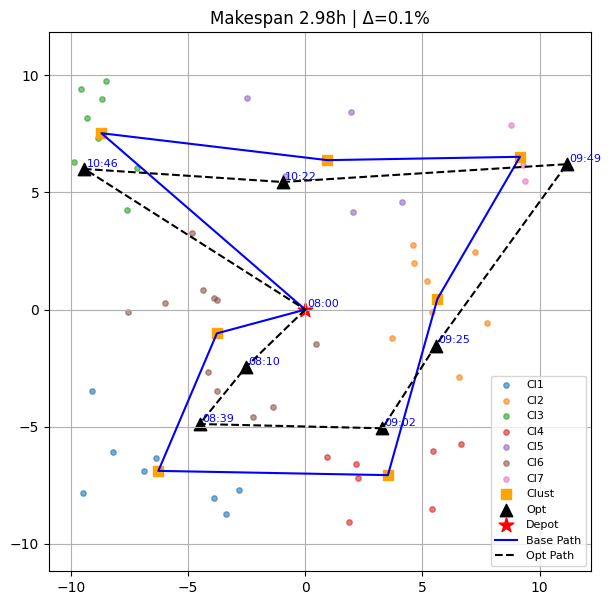


Done – baseline 2.99h, optimized 2.98h, Δ=0.1%


In [ ]:
# =============================================================
#  PTD-VRPD  ·  time‐dependent speed profile · cloud Gurobi
#            baseline vs. optimized (PSO)
# =============================================================

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pyswarm import pso
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0.  Cloud‐license credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395

def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env

GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1.  Global constants
# -------------------------------------------------------------
RNG_SEED           = 42
np.random.seed(RNG_SEED)

AREA_KM            = 10.0
N_DELIVERIES       = 50
DEPOT              = (0.0, 0.0)

DRONE_SPEED_KMH    = 40.0
DRONE_END_MIN      = 20
SERVICE_MIN_PER_CL = 5.0
BIGM               = 1e6

SWARM_SIZE   = 10
ITERATIONS   = 3
call_counter = 0
iter_counter = 0

BANDS      = np.arange(0, 24 + 0.25, 0.25)
SPEED_BAND = None
START_TIME = 8.0  # Start time for delivery process

# -------------------------------------------------------------
# 2.  Speed lookup + precompute per‐band speeds
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f = interp1d(df["Time of Day"] % 24,
                  df["Predicted Speed"],
                  kind="linear",
                  fill_value="extrapolate")
    global SPEED_BAND
    SPEED_BAND = f(BANDS)
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {f(9.5):.1f} km/h")
    return lambda t: float(f(t % 24))

speed_func = build_speed_func()

# -------------------------------------------------------------
# 3.  Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT,
                      np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K = 1
    while True:
        km = KMeans(n_clusters=K,
                    random_state=RNG_SEED,
                    n_init=10).fit(locs[1:])
        ok = True
        for i, ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i] - ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH + SERVICE_MIN_PER_CL/60.0
            if (rt > DRONE_END_MIN/60.0).any():
                ok = False
                break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K += 1

# -------------------------------------------------------------
# 4.  Build & solve MILP (with PWL + correct endurance)
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    """
    Builds and solves the time-dependent truck–drone MILP.
    Enforces:
      • Time‐dependent truck travel via PWL on Tdep → TT
      • Arrival→departure chaining: Tarr→Tdep ≥ Tarr + service + drone‐time
      • Drone‐endurance and dynamic Td = sum of assigned round‐trips
      • Standard MTZ subtour‐elimination for routing
    """
    # Number of stops = depot + each truck‐stop center
    nStop   = len(centres) + 1
    custIdx = np.arange(1, len(locs))  # indices of customer points

    # Precompute distance matrices
    xy   = np.vstack([DEPOT, centres])  # points for routing (depot + stops)
    Dman = cdist(xy, xy, metric="cityblock")
    Deuc = cdist(locs, xy)              # for drone endurance

    # Create Gurobi model
    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0
    m.Params.Threads = 8           # or however many cores you have
    m.Params.MIPFocus = 1          # (opt.) focus on finding good solutions quickly

    # === Decision variables ===
    # r[i,j] = 1 if truck goes directly from i to j
    r    = m.addVars(nStop, nStop, vtype=GRB.BINARY, name="r")
    # Tdep[i], Tarr[i] = departure/arrival times at stop i
    Tdep = m.addVars(nStop, lb=0.0, name="Tdep")
    Tarr = m.addVars(nStop, lb=0.0, name="Tarr")
    # TT[i,j] = travel time from i to j (time‐dependent)
    TT   = m.addVars(nStop, nStop, lb=0.0, name="TT")
    # Td[k] = total drone operation time at cluster k (k=0..len(centres)-1)
    Td   = m.addVars(len(centres), lb=0.0, name="Tdrone")
    # y[cIdx,k] = 1 if customer cIdx is served by drone at cluster k
    y    = m.addVars(len(custIdx), len(centres),
                     vtype=GRB.BINARY, name="y")

    # === Objective ===
    # Minimize total makespan = truck travel + drone times + service blocks
    m.setObjective(
        gp.quicksum(TT[i,j] * r[i,j]
                    for i in range(nStop) for j in range(nStop) if i != j)
      + gp.quicksum(Td[k] for k in range(len(centres)))
      + SERVICE_MIN_PER_CL/60.0 * len(centres),
      GRB.MINIMIZE)

    # === Routing & MTZ subtour elimination ===
    for i in range(nStop):
        # exactly one outbound and one inbound per node
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i) == 1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i) == 1)
    # MTZ variables
    u = m.addVars(nStop, lb=0.0, ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop), 2):
        m.addConstr(u[i] - u[j] + (nStop-1)*r[i,j] <= nStop-2)

    # === Time‐dependent travel via PWL + link Tarr ← Tdep + TT ===

    # --- 1. one PWL for invSpeed per stop ---
    inv_min = float(np.min(1/SPEED_BAND))
    inv_max = float(np.max(1/SPEED_BAND))
    invSpd = m.addVars(nStop, lb=inv_min, ub=inv_max, name="invSpd")
    for i in range(nStop):
        inv_vals = (1 / SPEED_BAND).tolist()              # same 96 break-points
        m.addGenConstrPWL(Tdep[i], invSpd[i],
                        BANDS.tolist(), inv_vals,
                        name=f"invPWL_{i}")

    # --- 2. TT[i,j] becomes linear in invSpd[i] ---
    for i in range(nStop):
        for j in range(nStop):
            if i == j: continue
            m.addConstr(
                TT[i,j] == Dman[i,j] * invSpd[i],
                name=f"TTdef_{i}_{j}"
            )
            # link arrival at j to departure+travel from i
            
            # lower‐bound (as before)
            m.addConstr(
                Tarr[j] >= Tdep[i] + TT[i, j] - BIGM * (1 - r[i, j]),
                name=f"timelink_lb_{i}_{j}"
            )

            # upper‐bound to force equality when r[i,j] == 1
            m.addConstr(
                Tarr[j] <= Tdep[i] + TT[i, j] + BIGM * (1 - r[i, j]),
                name=f"timelink_ub_{i}_{j}"
            )
    # truck starts at time 0
    m.addConstr(Tdep[0] == START_TIME)

    # === Departure chaining: wait for arrival + service + drones ===
    for i in range(1, nStop):
        # Td[i-1] is the drone‐block time for cluster i
        # DEPART IMMEDIATELY when ready
        m.addConstr(
            Tdep[i]
            == Tarr[i]
            + SERVICE_MIN_PER_CL/60.0
            + Td[i-1],
            name=f"depart_asap_after_{i}"
        )

    # === Drone assignment & endurance constraints ===
    for cIdx, cust in enumerate(custIdx):
        # Each customer must be served by exactly one drone/cluster
        m.addConstr(
            gp.quicksum(y[cIdx,k] for k in range(len(centres))) == 1,
            name=f"assignCust_{cIdx}"
        )
        for k in range(len(centres)):
            # round-trip time to that cluster
            rt = 2 * Deuc[cust, k+1] / DRONE_SPEED_KMH
            # endurance big-M: if y=1 then rt <= endurance
            m.addConstr(
                gp.LinExpr(rt - DRONE_END_MIN/60.0)
                <= BIGM * (1 - y[cIdx,k]),
                name=f"endurance_{cIdx}_{k}"
            )
            # accumulate drone times: Td[k] >= sum of all rt * y
            # we generate one constraint per (cust,k),
            # and the solver will push Td to the sum automatically.
            m.addConstr(
                Td[k] >= rt * y[cIdx,k],
                name=f"droneTime_{cIdx}_{k}"
            )

    # === Solve ===
    m.optimize()
    if m.SolCount == 0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return np.inf, m, r

    # === Extract objective components ===
    truck_time   = sum(TT[i,j].X * r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time   = sum(Td[k].X for k in range(len(centres)))
    service_time = SERVICE_MIN_PER_CL/60.0 * len(centres)
    total_time   = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"   → Truck   {truck_time:.3f} h | "
          f"Drone {drone_time:.3f} h | "
          f"Service {service_time:.3f} h | "
          f"Total  {total_time:.3f} h")
    return total_time, m, r

# -------------------------------------------------------------
# 5.  PSO fitness …
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    global call_counter, iter_counter
    call_counter += 1
    if call_counter % SWARM_SIZE == 0:
        iteration = call_counter // SWARM_SIZE
        if 1 <= iteration <= ITERATIONS:
            iter_counter = iteration
            print(f"[DEBUG][PSO] -- iter {iter_counter} --")

    particle_idx = ((call_counter - 1) % SWARM_SIZE) + 1
    K = len(centres0)
    ctrs = centres0 + w.reshape(K, 2)

    # endurance check (pre-MILP)
    for k, c in enumerate(ctrs):
        d  = np.linalg.norm(locs[1:][labels0==k] - c, axis=1)
        rt = 2 * d / DRONE_SPEED_KMH
        if (rt > DRONE_END_MIN/60.0).any():
            print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: "
                  f"endurance VIOLATION in cl {k}")
            return 1e6

    print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: centres OK")
    obj, _, _ = build_and_solve_milp(
        locs, ctrs, labels0,
        tag=f"[PSO it{iter_counter} p{particle_idx}]"
    )
    return 1e6 if np.isinf(obj) else obj

# -------------------------------------------------------------
# 6.  Extract route from r-vars
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop=int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt=next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7.  Main solver + plot
# -------------------------------------------------------------

def solve_and_plot(locs):
    global call_counter, iter_counter
    call_counter = iter_counter = 0

    # 1) Cluster by endurance
    labels0, centres0 = kmeans_endurance(locs)

    # 2) Baseline MILP
    base_time, base_mdl, base_r = build_and_solve_milp(
        locs, centres0, labels0, tag="[CLUSTER]")
    if np.isinf(base_time):
        raise RuntimeError("Baseline infeasible")

    # 3) PSO optimize
    lb = [-2] * (2 * len(centres0))
    ub = [ 2] * (2 * len(centres0))
    print("[DEBUG] Starting PSO…")
    w_best, f_best = pso(
        pso_fitness,
        lb, ub,
        swarmsize=SWARM_SIZE,
        maxiter=ITERATIONS,
        debug=False,
        args=(locs, centres0, labels0)
    )
    print(f"[DEBUG] PSO best obj = {f_best:.3f}h")

    # 4) Final optimized MILP
    centres_opt = centres0 if f_best >= 1e6 else centres0 + w_best.reshape(-1, 2)
    opt_time, opt_mdl, opt_r = build_and_solve_milp(
        locs, centres_opt, labels0, tag="[OPT   ]")
    if np.isinf(opt_time):
        centres_opt, opt_time, opt_r = centres0, base_time, base_r

    # 5) Summary
    improvement = 100 * (base_time - opt_time) / base_time
    print(f"\n[RESULT] Base  {base_time:.3f}h")
    print(f"[RESULT] Opt   {opt_time:.3f}h")
    print(f"[RESULT] Δ={improvement:.2f}%")

    # 6) Extract actual routes
    route_base = extract_route(base_r)
    route_opt  = extract_route(opt_r)

    # 7) Debug‐print departure times
    print("[DEBUG] Departure times for the *final* optimized route (clock‐time + elapsed):")
    for stop in route_opt[:-1]:   # skip final return‐to‐depot
        tvar = opt_mdl.getVarByName(f"Tdep[{stop}]")
        raw = tvar.X                       # raw = START_TIME + elapsed
        elapsed = raw - START_TIME        # elapsed since START_TIME

        # clock time
        clk = raw
        hh = int(clk) % 24
        mm = int((clk - int(clk)) * 60)

        # elapsed hours/minutes
        eh = int(elapsed)
        em = int((elapsed - int(elapsed)) * 60)

        print(f"   Stop {stop:2d} departs at {hh:02d}:{mm:02d}  (after +{eh:02d}h{em:02d}m)")

    # 8) Plot
    plt.figure(figsize=(7,7))
    # a) customer points
    for k in range(len(centres0)):
        pts = locs[1:][labels0 == k]
        plt.scatter(pts[:,0], pts[:,1], s=15, alpha=0.6, label=f'Cl{k+1}')
    # b) cluster centers & optimized
    plt.scatter(centres0[:,0], centres0[:,1],
                marker='s', c='orange', s=60, label='Clust')
    plt.scatter(centres_opt[:,0], centres_opt[:,1],
                marker='^', c='k', s=80, label='Opt')
    # c) depot
    plt.scatter(*DEPOT, marker='*', c='r', s=120, label='Depot')
    # d) paths
    pb = np.vstack([DEPOT, centres0])[route_base]
    plt.plot(pb[:,0], pb[:,1], 'b-', lw=1.5, label='Base Path')
    po = np.vstack([DEPOT, centres_opt])[route_opt]
    plt.plot(po[:,0], po[:,1], 'k--', lw=1.5, label='Opt Path')
    # e) annotate visited stops
    for (x, y), stop in zip(po[:-1], route_opt[:-1]):
        tvar = opt_mdl.getVarByName(f"Tdep[{stop}]")
        raw = tvar.X
        clk = raw
        hh = int(clk) % 24
        mm = int((clk - int(clk)) * 60)
        plt.text(x + 0.1, y + 0.1, f"{hh:02d}:{mm:02d}", fontsize=8, color='blue')

    plt.title(f'Makespan {opt_time:.2f}h | Δ={improvement:.1f}%')
    plt.legend(fontsize=8)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    return base_time, opt_time, improvement



# -------------------------------------------------------------
# 8.  Demo run
# -------------------------------------------------------------
if __name__ == "__main__":
    locs = gen_locations()
    base, opt, impr = solve_and_plot(locs)
    print(f"\nDone – baseline {base:.2f}h, optimized {opt:.2f}h, Δ={impr:.1f}%")


In [ ]:
# =============================================================
#  PTD-VRPD  ·  time‐dependent speed profile · cloud Gurobi
#            baseline vs. optimized (PSO)
# =============================================================

import numpy as np, pandas as pd, itertools, matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from pyswarm import pso
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

# -------------------------------------------------------------
# 0.  Cloud‐license credentials
# -------------------------------------------------------------
WLS_ID     = "95c3994f-513d-4b8c-a42c-0194dad8ec5c"
WLS_SECRET = "3dc0e444-1f74-49f3-96cc-e9abaabb8ce4"
LICENSE_ID = 2551395

def make_env():
    env = gp.Env(empty=True)
    env.setParam("WLSACCESSID", WLS_ID)
    env.setParam("WLSSECRET",   WLS_SECRET)
    env.setParam("LICENSEID",   LICENSE_ID)
    env.setParam("OutputFlag",  0)
    env.start()
    return env

GRB_ENV = make_env()
print("[DEBUG] Gurobi cloud environment initialized.")

# -------------------------------------------------------------
# 1.  Global constants
# -------------------------------------------------------------
RNG_SEED           = 42
np.random.seed(RNG_SEED)

AREA_KM            = 10.0
N_DELIVERIES       = 50
DEPOT              = (0.0, 0.0)

DRONE_SPEED_KMH    = 40.0
N_DRONES           = 10
DRONE_END_MIN      = 20
SERVICE_MIN_PER_CL = 5.0
BIGM               = 1e6

SWARM_SIZE   = 30
ITERATIONS   = 5
call_counter = 0
iter_counter = 0

BANDS      = np.arange(0, 24 + 0.25, 0.25)
SPEED_BAND = None
START_TIME = 8.0  # Start time for delivery process

# -------------------------------------------------------------
# 2.  Speed lookup + precompute per‐band speeds
# -------------------------------------------------------------
def build_speed_func(csv_path="Predicted Speed/Predicted_Speeds.csv"):
    df = pd.read_csv(csv_path).rename(columns=str.strip)
    if not {"Time of Day","Predicted Speed"}.issubset(df.columns):
        raise ValueError("CSV must contain 'Time of Day' + 'Predicted Speed'")
    df = df.sort_values("Time of Day")
    f = interp1d(df["Time of Day"] % 24,
                  df["Predicted Speed"],
                  kind="linear",
                  fill_value="extrapolate")
    global SPEED_BAND
    SPEED_BAND = f(BANDS)
    print(f"[DEBUG] Loaded {len(df)} speed points – example 09:30 ⇒ {f(9.5):.1f} km/h")
    return lambda t: float(f(t % 24))

speed_func = build_speed_func()

# -------------------------------------------------------------
# 3.  Instance helpers
# -------------------------------------------------------------
def gen_locations(n=N_DELIVERIES, area=AREA_KM):
    locs = np.vstack([DEPOT,
                      np.random.uniform(-area, area, size=(n,2))])
    print(f"[DEBUG] Generated {n} delivery locations.")
    return locs

def kmeans_endurance(locs):
    K = 1
    while True:
        km = KMeans(n_clusters=K,
                    random_state=RNG_SEED,
                    n_init=10).fit(locs[1:])
        ok = True
        for i, ctr in enumerate(km.cluster_centers_):
            dkm = np.linalg.norm(locs[1:][km.labels_==i] - ctr, axis=1)
            rt  = 2*dkm/DRONE_SPEED_KMH
            if (rt > DRONE_END_MIN/60.0).any():
                ok = False
                break
        if ok:
            print(f"[DEBUG] K-means found feasible K={K} clusters.")
            return km.labels_, km.cluster_centers_
        K += 1

# -------------------------------------------------------------
# 4.  Build & solve MILP (with PWL + correct endurance)
# -------------------------------------------------------------
def build_and_solve_milp(locs, centres, labels, tag=""):
    """
    Builds and solves the time-dependent truck–drone MILP.
    Enforces:
      • Time‐dependent truck travel via PWL on Tdep → TT
      • Arrival→departure chaining: Tarr→Tdep ≥ Tarr + service + drone‐time
      • Drone‐endurance and dynamic Tdrone = max accumulated sorties per drone
      • Standard MTZ subtour‐elimination for routing
    """
    # Number of stops = depot + each truck‐stop center
    nStop   = len(centres) + 1
    custIdx = np.arange(1, len(locs))  # indices of customer points

    # Precompute distance matrices
    xy   = np.vstack([DEPOT, centres])  # points for routing (depot + stops)
    Dman = cdist(xy, xy, metric="cityblock")
    Deuc = cdist(locs, xy)              # for drone endurance

    # Create Gurobi model
    m = gp.Model(env=GRB_ENV)
    m.Params.OutputFlag = 0
    m.Params.Threads = 8
    m.Params.MIPFocus = 1

    # === Decision variables ===
    # r[i,j] = 1 if truck goes directly from i to j
    r    = m.addVars(nStop, nStop, vtype=GRB.BINARY, name="r")
    # Tdep[i], Tarr[i] = departure/arrival times at stop i
    Tdep = m.addVars(nStop, lb=0.0, name="Tdep")
    Tarr = m.addVars(nStop, lb=0.0, name="Tarr")
    # TT[i,j] = travel time from i to j (time-dependent)
    TT   = m.addVars(nStop, nStop, lb=0.0, name="TT")
    # y[cIdx,i,k] = 1 if customer cIdx is served by drone k at cluster i
    y      = m.addVars(len(custIdx), len(centres), N_DRONES,
                       vtype=GRB.BINARY, name="y")
    # Accumulated flight time per cluster i and drone k
    Td_acc = m.addVars(len(centres), N_DRONES, lb=0.0, name="Td_acc")
    # Cluster-wide drone-phase makespan
    Tdrone = m.addVars(len(centres), lb=0.0, name="Tdrone")
    
    
    # ── FIX: force each customer into its original K-means cluster ──
    for cIdx in range(len(custIdx)):
        for i in range(len(centres)):
            if labels[cIdx] != i:
                for k in range(N_DRONES):
                    y[cIdx, i, k].ub = 0
                    

    # === Objective ===
    # Minimize total makespan = truck travel + drone times + service blocks
    m.setObjective(
        gp.quicksum(TT[i,j] * r[i,j]
                    for i in range(nStop) for j in range(nStop) if i != j)
      + gp.quicksum(Tdrone[i] for i in range(len(centres)))
      + SERVICE_MIN_PER_CL/60.0 * len(centres),
      GRB.MINIMIZE)

    # === Routing & MTZ subtour elimination ===
    for i in range(nStop):
        m.addConstr(gp.quicksum(r[i,j] for j in range(nStop) if j!=i) == 1)
        m.addConstr(gp.quicksum(r[j,i] for j in range(nStop) if j!=i) == 1)
    u = m.addVars(nStop, lb=0.0, ub=nStop-1, name="u")
    for i,j in itertools.permutations(range(1,nStop), 2):
        m.addConstr(u[i] - u[j] + (nStop-1)*r[i,j] <= nStop-2)

    # === Time-dependent travel via PWL + link Tarr ← Tdep + TT ===
    inv_min = float(np.min(1/SPEED_BAND))
    inv_max = float(np.max(1/SPEED_BAND))
    invSpd = m.addVars(nStop, lb=inv_min, ub=inv_max, name="invSpd")
    for i in range(nStop):
        inv_vals = (1 / SPEED_BAND).tolist()
        m.addGenConstrPWL(Tdep[i], invSpd[i],
                          BANDS.tolist(), inv_vals,
                          name=f"invPWL_{i}")
    for i in range(nStop):
        for j in range(nStop):
            if i==j: continue
            m.addConstr(TT[i,j] == Dman[i,j] * invSpd[i], name=f"TTdef_{i}_{j}")
            m.addConstr(
                Tarr[j] >= Tdep[i] + TT[i,j] - BIGM*(1 - r[i,j]),
                name=f"timelink_lb_{i}_{j}")
            m.addConstr(
                Tarr[j] <= Tdep[i] + TT[i,j] + BIGM*(1 - r[i,j]),
                name=f"timelink_ub_{i}_{j}")
    m.addConstr(Tdep[0] == START_TIME)

    # === Departure chaining ===
    for i in range(1, nStop):
        m.addConstr(
            Tdep[i] == Tarr[i]
                     + SERVICE_MIN_PER_CL/60.0
                     + Tdrone[i-1],
            name=f"depart_asap_after_{i}"
        )

    # === Drone assignment, finite fleet & accumulation ===
    for cIdx, cust in enumerate(custIdx):
        m.addConstr(
            gp.quicksum(y[cIdx,i,k]
                        for i in range(len(centres))
                        for k in range(N_DRONES)) == 1,
            name=f"assignCust_{cIdx}"
        )
        for i in range(len(centres)):
            rt = 2 * Deuc[cust, i+1] / DRONE_SPEED_KMH
            for k in range(N_DRONES):
                m.addConstr(
                    gp.LinExpr(rt) <= DRONE_END_MIN/60.0 + BIGM*(1 - y[cIdx,i,k]),
                    name=f"endurance_{cIdx}_{i}_{k}"
                )
    
    for i in range(len(centres)):
        for k in range(N_DRONES):
            m.addConstr(
                Td_acc[i, k] == gp.quicksum(
                    (2 * Deuc[cust, i+1] / DRONE_SPEED_KMH) *
                        y[cIdx, i, k]
                    for cIdx, cust in enumerate(custIdx)
                ),
                name=f"accum_sum_{i}_{k}"
            )
    for i in range(len(centres)):
        for k in range(N_DRONES):
            m.addConstr(
                Tdrone[i] >= Td_acc[i,k],
                name=f"makespan_{i}_{k}"
            )

    # === Solve ===
    m.optimize()
    if m.SolCount == 0:
        print(f"[DEBUG]{tag} MILP infeasible.")
        return np.inf, m, r

    # === Extract objective components ===
    truck_time   = sum(TT[i,j].X * r[i,j].X
                       for i in range(nStop) for j in range(nStop) if i!=j)
    drone_time   = sum(Tdrone[i].X for i in range(len(centres)))
    service_time = SERVICE_MIN_PER_CL/60.0 * len(centres)
    total_time   = truck_time + drone_time + service_time

    print(f"[DEBUG]{tag} MILP solved:")
    print(f"   → Truck   {truck_time:.3f} h | "
          f"Drone {drone_time:.3f} h | "
          f"Service {service_time:.3f} h | "
          f"Total  {total_time:.3f} h")
    return total_time, m, r


# -------------------------------------------------------------
# 5.  PSO fitness …
# -------------------------------------------------------------
def pso_fitness(w, locs, centres0, labels0):
    global call_counter, iter_counter
    call_counter += 1
    if call_counter % SWARM_SIZE == 0:
        iteration = call_counter // SWARM_SIZE
        if 1 <= iteration <= ITERATIONS:
            iter_counter = iteration
            print(f"[DEBUG][PSO] -- iter {iter_counter} --")

    particle_idx = ((call_counter - 1) % SWARM_SIZE) + 1
    K = len(centres0)
    ctrs = centres0 + w.reshape(K, 2)

    # endurance check (pre-MILP)
    for k, c in enumerate(ctrs):
        d  = np.linalg.norm(locs[1:][labels0==k] - c, axis=1)
        rt = 2 * d / DRONE_SPEED_KMH
        if (rt > DRONE_END_MIN/60.0).any():
            print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: "
                  f"endurance VIOLATION in cl {k}")
            return 1e6

    print(f"[DEBUG][PSO] it{iter_counter} p{particle_idx}: centres OK")
    obj, _, _ = build_and_solve_milp(
        locs, ctrs, labels0,
        tag=f"[PSO it{iter_counter} p{particle_idx}]"
    )
    return 1e6 if np.isinf(obj) else obj

# -------------------------------------------------------------
# 6.  Extract route from r-vars
# -------------------------------------------------------------
def extract_route(r_vars):
    edges = {(i,j) for (i,j),v in r_vars.items() if v.X>0.5}
    route=[0]
    nStop=int(np.sqrt(len(r_vars)))
    while len(route)<nStop+1:
        last=route[-1]
        nxt=next(j for (i,j) in edges if i==last)
        route.append(nxt)
        if nxt==0: break
    print(f"[DEBUG] Extracted route: {route}")
    return route

# -------------------------------------------------------------
# 7.  Main solver + plot
# -------------------------------------------------------------

def solve_and_plot(locs):
    global call_counter, iter_counter
    call_counter = iter_counter = 0

    # 1) Cluster by endurance
    labels0, centres0 = kmeans_endurance(locs)

    # 2) Baseline MILP
    base_time, base_mdl, base_r = build_and_solve_milp(
        locs, centres0, labels0, tag="[CLUSTER]")
    if np.isinf(base_time):
        raise RuntimeError("Baseline infeasible")

    # 3) PSO optimize
    lb = [-2] * (2 * len(centres0))
    ub = [ 2] * (2 * len(centres0))
    print("[DEBUG] Starting PSO…")
    w_best, f_best = pso(
        pso_fitness,
        lb, ub,
        swarmsize=SWARM_SIZE,
        maxiter=ITERATIONS,
        debug=False,
        args=(locs, centres0, labels0)
    )
    print(f"[DEBUG] PSO best obj = {f_best:.3f}h")

    # 4) Final optimized MILP
    centres_opt = centres0 if f_best >= 1e6 else centres0 + w_best.reshape(-1, 2)
    opt_time, opt_mdl, opt_r = build_and_solve_milp(
        locs, centres_opt, labels0, tag="[OPT   ]")
    if np.isinf(opt_time):
        centres_opt, opt_time, opt_r = centres0, base_time, base_r

    # 5) Summary
    improvement = 100 * (base_time - opt_time) / base_time
    print(f"\n[RESULT] Base  {base_time:.3f}h")
    print(f"[RESULT] Opt   {opt_time:.3f}h")
    print(f"[RESULT] Δ={improvement:.2f}%")

    # 6) Extract actual routes
    route_base = extract_route(base_r)
    route_opt  = extract_route(opt_r)

    # 7) Debug‐print departure times
    print("[DEBUG] Departure times for the *final* optimized route (clock‐time + elapsed):")
    for stop in route_opt[:-1]:   # skip final return‐to‐depot
        tvar = opt_mdl.getVarByName(f"Tdep[{stop}]")
        raw = tvar.X                       # raw = START_TIME + elapsed
        elapsed = raw - START_TIME        # elapsed since START_TIME

        # clock time
        clk = raw
        hh = int(clk) % 24
        mm = int((clk - int(clk)) * 60)

        # elapsed hours/minutes
        eh = int(elapsed)
        em = int((elapsed - int(elapsed)) * 60)

        print(f"   Stop {stop:2d} departs at {hh:02d}:{mm:02d}  (after +{eh:02d}h{em:02d}m)")

    # 8) Plot
    plt.figure(figsize=(7,7))
    # a) customer points
    for k in range(len(centres0)):
        pts = locs[1:][labels0 == k]
        plt.scatter(pts[:,0], pts[:,1], s=15, alpha=0.6, label=f'Cl{k+1}')
    # b) cluster centers & optimized
    plt.scatter(centres0[:,0], centres0[:,1],
                marker='s', c='orange', s=60, label='Clust')
    plt.scatter(centres_opt[:,0], centres_opt[:,1],
                marker='^', c='k', s=80, label='Opt')
    # c) depot
    plt.scatter(*DEPOT, marker='*', c='r', s=120, label='Depot')
    # d) paths
    pb = np.vstack([DEPOT, centres0])[route_base]
    plt.plot(pb[:,0], pb[:,1], 'b-', lw=1.5, label='Base Path')
    po = np.vstack([DEPOT, centres_opt])[route_opt]
    plt.plot(po[:,0], po[:,1], 'k--', lw=1.5, label='Opt Path')
    # e) annotate visited stops
    for (x, y), stop in zip(po[:-1], route_opt[:-1]):
        tvar = opt_mdl.getVarByName(f"Tdep[{stop}]")
        raw = tvar.X
        clk = raw
        hh = int(clk) % 24
        mm = int((clk - int(clk)) * 60)
        plt.text(x + 0.1, y + 0.1, f"{hh:02d}:{mm:02d}", fontsize=8, color='blue')

    plt.title(f'Makespan {opt_time:.2f}h | Δ={improvement:.1f}%')
    plt.legend(fontsize=8)
    plt.axis('equal')
    plt.grid(True)
    plt.show()

    return base_time, opt_time, improvement



# -------------------------------------------------------------
# 8.  Demo run
# -------------------------------------------------------------
if __name__ == "__main__":
    locs = gen_locations()
    base, opt, impr = solve_and_plot(locs)
    print(f"\nDone – baseline {base:.2f}h, optimized {opt:.2f}h, Δ={impr:.1f}%")
